In [1]:
# This is only for plotting in the paper
# Created by Jiawen Li
# 12/12/2022
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
from pylab import *
from matplotlib import container
import matplotlib.ticker as ticker
from scipy.stats import chi2
import pylab
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline

# Font dictionary
font = {'family': 'sans serif',
        'color':  'black',
        'weight': 'normal',
        'size': 36,
        }
font_labels = {'family': 'sans serif',
               'color':  'black',
               'weight': 'normal',
               'size': 36,
                }
font_ticks = {'family': 'sans serif',
               'color':  'black',
               'weight': 'normal',
               'size': 32,
                }
plt.rcParams['savefig.facecolor']='white'
xls_file = pd.ExcelFile('Mcaps_Clumped_data_plotting.xlsx')
data  = xls_file.parse('Mcaps_clumped_data_Summary')
equib = xls_file.parse('Equilibrium')
# Append the avg zero to the sheet
#Search for data from different temperatures
# 1 is 37; 2 is 27; 3 is room temp
Temp_37=data[data['Labels']==1]
Temp_27=data[data['Labels']==2]
Temp_21=data[data['Labels']==3]
Cu_free=data[data['Labels']==5]
High_Cu=data[data['Labels']==6]
D1500=data[data['Labels']=='D1']
D3000=data[data['Labels']=='D2']
# Sort from large to small
Temp_21=Temp_21.sort_values(by=['f'],ascending=False)
Temp_27=Temp_27.sort_values(by=['f'],ascending=False)
Temp_37=Temp_37.sort_values(by=['f'],ascending=False)
Cu_free=Cu_free.sort_values(by=['f'],ascending=False)
High_Cu=High_Cu.sort_values(by=['f'],ascending=False)
D1500=D1500.sort_values(by=['f'],ascending=False)
D3000=D3000.sort_values(by=['f'],ascending=False)
# Divide the 37 C data into f>0.5 and f<0.5
Temp_37h=Temp_37[Temp_37["f"]>=0.66]
Temp_37l=Temp_37[Temp_37["f"]<0.66]
# 11,21 and 31 are outliers for three groups
# Temp_37_o=data.loc[data[data['Labels']==11].index]
# Temp_27_o=data.loc[data[data['Labels']==21].index]
# Temp_21_o=data.loc[data[data['Labels']==31].index]
# Cu_free_o=data.loc[data[data['Labels']==51].index]
# High_Cu_o=data.loc[data[data['Labels']==61].index]
#Data from Krause et al., 2022
krause=data[data['Labels']=='k']
# Data from Wange et al., 2016
w37=data[data['Labels']=='w37']
w30=data[data['Labels']=='w30']
#Find zero points
zero=data[data['Labels']==0]
zero_krause=data[data['Labels']=='0k']
#Define a function to transform data into list for plotting
def read_data(filename):
    a_file = open(filename, "r")
    data=a_file.read()
    model_data=[]
    lines=data.strip().split('\n')
    for line in lines:
        model_data.append(float(line))
    a_file.close()
    return model_data
# Function for calculating fractionation factors
# Temp is the data, Temp_zero is the zero point used for regression
# T is for a string for experimental condition in the legend
# axC and axH are the axes to plot on
# T0 is a bool (1 or 0) to indicate whether the starting f is 1 or not
# Style is the marker style [marker, color]
def aCaH(Temp, Temp_zero, T, T0):
    if T0:
        rC=[0]
        rH=[0]
        logf=[0]
    else:
        rC=[]
        rH=[]
        logf=[]
    logf_plot=-np.linspace(-2,0,11)    
    for i in Temp['d13C PDB']:
        rC.append(math.log((i+1000)/(Temp_zero['d13C PDB']+1000)))
    for j in Temp['f']:
        logf.append(-math.log(j))
    slope_C, intercept_C, r_value_C, _value_C, std_err_C = scipy.stats.linregress(logf,rC)
    alphaC=1-slope_C
    for k in Temp['dD SMOW']:
        rH.append(math.log((k+1000)/(Temp_zero['dD SMOW']+1000)))
    slope_H, intercept_H, r_value_H, _value_H, std_err_H = scipy.stats.linregress(logf,rH)
    alphaH=1-slope_H
    print('%25s %15.4f %15.4f %15.4f %15.4f'%(T, alphaH, r_value_H**2, alphaC, r_value_C**2))
    return slope_C,intercept_C,slope_H,intercept_H,logf,rC,rH
# Define function for clumpe, could combine with bulk in the future
def a_clumped(Temp, Temp_zero, T, T0):
    if T0:
        logf=[0]
        r13CD=[0]
        rD2=[0]
    else:
        logf=[]
        r13CD=[]
        rD2=[]
    logf_plot=-np.linspace(-2,0,11)    
    for i in Temp['d13CH3D meas.']:
        r13CD.append(math.log((i+1000)/(Temp_zero['d13CH3D meas.']+1000)))
    for j in Temp['f']:
        logf.append(-math.log(j))
    for k in Temp['d12CH2D2 meas.']:
        rD2.append(math.log((k+1000)/(Temp_zero['d12CH2D2 meas.']+1000)))
#     ax_13CD.scatter(logf,r13CD, label=T,s=120)
#     ax_13CD.set_xlabel('-lnf',fontdict=font_labels)
#     ax_13CD.set_ylabel(r'ln$\frac{\delta^{13}CH_3D+1000}{\delta^{13}CH_3D_{ini}+1000}$',fontdict=font_labels)
#     ax_13CD.set_title(r'Regression for $^{13CD}\alpha$',fontdict=font)
    slope_13CD, intercept_13CD, r_value_13CD, _value_13CD, std_err_13CD = scipy.stats.linregress(logf,r13CD)
    alpha_13CD=1-slope_13CD
#     ax_D2.scatter(logf,rD2, label=T,s=120)
#     ax_D2.set_xlabel('-lnf',fontdict=font_labels)
#     ax_D2.set_ylabel(r'ln$\frac{\delta^{12}CH_2D_2+1000}{\delta^{12}CH_2D_{2 ini}+1000}$',fontdict=font_labels)
#     ax_D2.set_title(r'Regression for $^{D2}\alpha$',fontdict=font)
    slope_D2, intercept_D2, r_value_D2, _value_D2, std_err_D2 = scipy.stats.linregress(logf,rD2)
    alpha_D2=1-slope_D2
    print('%25s %15.4f %15.4f %15.4f %15.4f'%(T, alpha_13CD, r_value_13CD**2, alpha_D2, r_value_D2**2))
#     # plot the regression line
#     CD_plot=slope_13CD*logf_plot+intercept_13CD
#     ax_13CD.plot(logf_plot,CD_plot,'--')
#     ax_13CD.legend()
#     D2_plot=slope_D2*logf_plot+intercept_D2
#     ax_D2.plot(logf_plot,D2_plot,'--')
#     ax_D2.legend()
    return slope_13CD,intercept_13CD,slope_D2,intercept_D2,logf,r13CD,rD2

# Define a function for plotting growth curves (with f on x axis)
# Style is the fmt of the curve, ax is the axis
def gcf(raw_data,ax,name,style,c):
    data=pd.read_excel(raw_data)
    f=data["f"]
    ferr=data["stdevf"]
    OD=data["avgOD"]
    ODerr=data["stdevOD"]
    mask=np.isfinite(f)
    if logscale==False:
        ax.errorbar(f[mask],OD[mask],xerr=ferr[mask],yerr=ODerr[mask],
                    fmt=style, color=c, markerfacecolor=c, markeredgecolor='black',ecolor='black',
                    markersize=14, linewidth=3,label=name)
    if logscale==True:
        ax.errorbar(f[mask],np.log(OD)[mask],xerr=ferr[mask],yerr=ODerr[mask]/OD[mask],
                    fmt=style, color=c, markerfacecolor=c, markeredgecolor='black', ecolor='black',
                    markersize=14, linewidth=3,label=name)
    ax.set_xlabel("Fraction of residual methane (f)",fontdict=font_labels)
    ax.set_ylabel("log(OD)",fontdict=font_labels)

# Define a function to plot the growth curves with time
def gct(raw_data,ax,name,style,c):
    growthdf=pd.read_excel(raw_data)
    elapse_time=[0]
    OD=growthdf["avgOD"]
    ODerr=growthdf["stdevOD"]
    # mask=np.isfinite(growthdf["f"])
    for i in range (len(growthdf['Timestamp'])-1):
        elapse_time.append((growthdf['Timestamp'][i+1]-growthdf['Timestamp'][0])/pd.to_timedelta(1, unit='hr')) # Covert the time difference to hrs
    if logscale==False:
        ax.errorbar(elapse_time, OD, yerr=ODerr, 
                    fmt=style, color=c, markerfacecolor=c, markeredgecolor='black', ecolor='black', label=name,
                    linewidth=3, markersize = 14)
    if logscale==True:
        ax.errorbar(elapse_time, np.log(OD), yerr=ODerr/OD, 
                    fmt=style, color=c, markerfacecolor=c, markeredgecolor='black', ecolor='black',label=name,
                    linewidth=3, markersize = 14)
    ax.set_xlabel('Time (hrs)',fontdict=font_labels)
    ax.set_ylabel('log(OD)',fontdict=font_labels)


# Also plot methane concentration with time
def met(raw_data,ax,name,style, c):
    elapse_time=[]
    growthdf=pd.read_excel(raw_data)
    OD=growthdf["avgOD"]
    ODerr=growthdf["stdevOD"]
    cerr=growthdf["c 1 se"]
    time=growthdf["Timestamp"]
    ch4=growthdf["methane concentration (umol)"]
    mask=np.isfinite(growthdf["f"])
    efftime=time[mask]
    l=efftime.index.values
    for i in range(len(l)):
        elapse_time.append((time[l[i]]-time[0])/pd.to_timedelta(1, unit='hr')) # Covert the time difference to hrs
    ax.errorbar(elapse_time, ch4[mask], yerr=cerr[mask], 
                fmt=style, color=c, markerfacecolor=c, markeredgecolor='black', ecolor='black',label=name,
                linewidth=3, markersize = 14)
    ax.set_xlabel('Time (hrs)',fontdict=font_labels)
    ax.set_ylabel('Residual methane ($\mu$mol)',fontdict=font_labels)    

def York_regression(data_table,R,Rerr):
    X = data_table['lnf']
    y = data_table[R]
    sigX = data_table['lnf 1 se']
    sigy = data_table[Rerr]
    r = 0 # no covariance
    
    b = -1  
    for iter in range(500):    
        b0 = b
        #   Weights...
        wt = 1/( sigy**2 + (b**2)*(sigX**2) - 2*r*sigX*sigy )       
        #   centroid (weighted mean) 
        sXoss = np.sum(X*wt) / np.sum(wt)
        syoss = np.sum(y*wt) / np.sum(wt) 

        # Calculate intercept a and slope b.
        t1 = (X-sXoss)*(sigy**2)
        t2 = (y-syoss)*(sigX**2)*b
        t3 = sigX*sigy*r
        st2 = np.sum( (wt**2)*(y-syoss)*(t1+t2-t3*(y-syoss)) )
        st3 = np.sum( (wt**2)*(X-sXoss)*(t1+t2-b*t3*(X-sXoss)) )    
        b = st2/st3
        #print(b)
        if abs(b-b0)<10**(-8): break  

    # best fit slope and intercept 
    fit_slope = b
    fit_intercept = syoss - sXoss*fit_slope 
    
    # Calculate errors in intercept and slope
    sig_slope = np.sqrt(1/np.sum(wt*(X-sXoss)**2))
    sig_intercept = sig_slope * np.sqrt(np.sum(wt*X**2/np.sum(wt)))

    # Calculate chi squared statistic
    # (sum of squared deviations from the best-fit line)
    chi_2 = np.sum(wt*(y-fit_intercept-fit_slope*X)**2)
    df = len(y)-2
    # Compute reduced chi squared
    rchi_2 = chi_2/df 

    # Compute "goodness of fit"
    # q is the probability that chi^2 should exceed the statistic X^2
    q = 1-chi2.cdf(rchi_2,df)
    
    return fit_slope, fit_intercept, sig_slope, sig_intercept, chi_2, rchi_2, q, sXoss, syoss    
    
# define a function to spit out the slope, intercept, and rchi_2 of the regressions
def calculate_alpha(data_table, name):
    slope_C, intercept_C, sig_slope_C, sig_intercept_C, chi_2_C, rchi_2_C, q_C, sXoss_C, syoss_C = York_regression(data_table,"rC","rC 1 se")
    slope_H, intercept_H, sig_slope_H, sig_intercept_H, chi_2_H, rchi_2_H, q_H, sXoss_H, syoss_H = York_regression(data_table,"rH","rH 1 se")
    slope_13CD, intercept_13CD, sig_slope_13CD, sig_intercept_13CD, chi_2_13CD, rchi_2_13CD, q_13CD, sXoss_13CD, syoss_13CD = York_regression(data_table,"r13CD","r13CD 1 se")
    slope_D2, intercept_D2, sig_slope_D2, sig_intercept_D2, chi_2_D2, rchi_2_D2, q_D2, sXoss_D2, syoss_D2 = York_regression(data_table,"rDD","rDD 1 se")
    print('%12s %12.4f %12.4f %12.4f %12.4f %12.4f %12.4f %12.4f %12.4f'%(name, 1-slope_H, sig_slope_H, 1-slope_C, sig_slope_C, 1-slope_13CD, sig_slope_13CD, 1-slope_D2, sig_slope_D2))
    print('%12.4f %12.4f %12.4f %12.4f' %(rchi_2_C, rchi_2_H, rchi_2_13CD, rchi_2_D2))
    
    return slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2

# Define a function to read the modeled data
def read_model(name):
    D12CH2D2_model=read_data("Modeling/" + name + "_D12CH2D2_output.txt")
    D13CH3D_model=read_data("Modeling/" + name + "_D13CH3D_output.txt")
    d13C_model=read_data("Modeling/" + name + "_d13C_CH4_output.txt")
    dD_model=read_data("Modeling/" + name + "_dD_CH4_output.txt")
    return D12CH2D2_model, D13CH3D_model, d13C_model, dD_model

# D3000

                             Temperature  Doubling time (hrs)
               07/20/2022 37C exp redone          5.6628
          08/22/2022 0 Cu exp for clumps          7.8514
                      10/25/2021 5uM 37C          8.3573
         08/24/2022 50 Cu exp for clumps         17.5517
                      06/09/2021 5uM 27C         52.4226
                      01/17/2022 5uM 21C        113.0693


<ipython-input-2-02ca6ed9dabe>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rate.set_yticklabels(ax_rate.get_yticks(),fontdict=font_ticks)


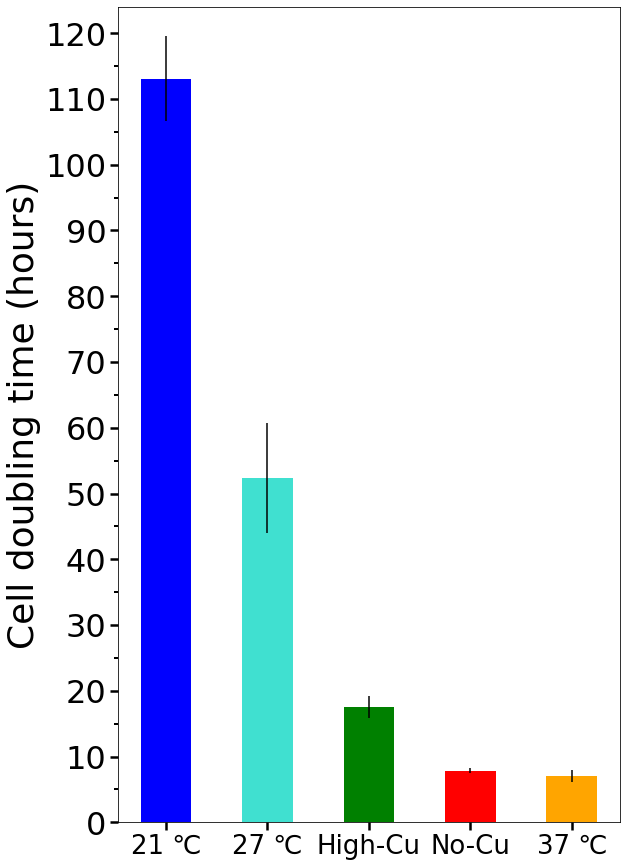

<ipython-input-2-02ca6ed9dabe>:116: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_clump.set_yticklabels(ax_clump.get_yticks(),fontdict=font_ticks)
<ipython-input-2-02ca6ed9dabe>:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_clump.set_xticklabels(ax_clump.get_xticks(),fontdict=font_ticks)


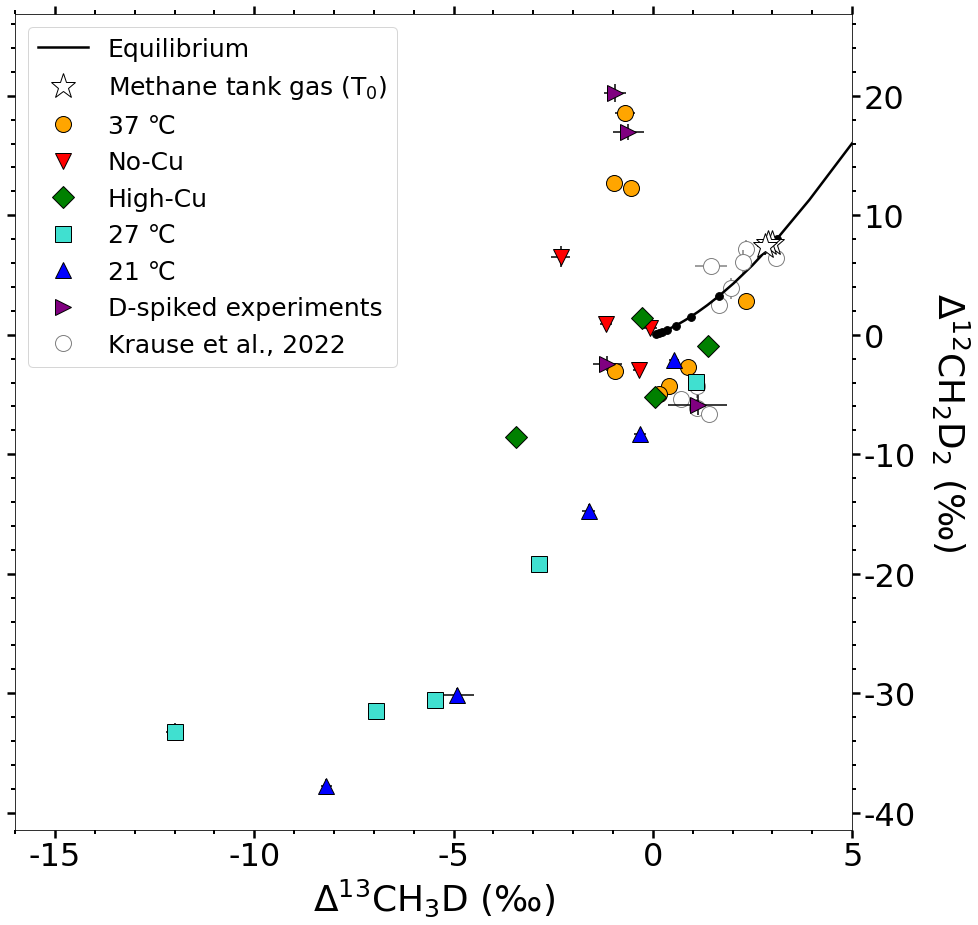

In [2]:
#Print the doubling time of the experiments
print('%40s %20s' %('Temperature','Doubling time (hrs)'))
print('%40s %15.4f' %('07/20/2022 37C exp redone',5.662847684))
print('%40s %15.4f' %('08/22/2022 0 Cu exp for clumps',7.851413533))
print('%40s %15.4f' %('10/25/2021 5uM 37C',8.357284304))
print('%40s %15.4f' %('08/24/2022 50 Cu exp for clumps',17.55169064))
print('%40s %15.4f' %('06/09/2021 5uM 27C',52.42263959))
print('%40s %15.4f' %('01/17/2022 5uM 21C',113.0693231))
# Plot the growth rates
fig_rate, ax_rate = plt.subplots(figsize=(9,15))
# objects = ['37 \u2103 \n 5 $\mu$M', '37 \u2103 \n 0 $\mu$M',
#            '37 \u2103 \n 50 $\mu$M', '27 \u2103 \n 5 $\mu$M', '21 \u2103 \n 5 $\mu$M']
# objects = ['37 \n 5', '37 \n 0',
#            '37 \n 50', '27 \n 5', '21 \n 5']
objects = ['37 \u2103', 'No-Cu',
           'High-Cu', '27 \u2103', '21 \u2103']
objects.reverse()
y_pos = np.arange(len(objects))
DT = [7.010065994,
7.851413533,
17.55169064,
52.42263959,
113.0693231]
DT.reverse()
DT_err=[0.952627203,
0.396960767,
1.729846321,
8.352836613,
6.483085074]
DT_err.reverse()
cbar=['orange','red','green','turquoise','blue']
cbar.reverse()
ax_rate.bar(y_pos, DT, yerr=DT_err,color= cbar,align='center', width=0.5)
ax_rate.set_xticks(y_pos)
ax_rate.set_xticklabels(objects,fontdict=font_ticks)
#                        ,rotation=45,ha='right',va='top')
ax_rate.tick_params(axis="x", labelsize=26)
ax_rate.set_ylim([0,124])
ax_rate.yaxis.set_major_locator(MultipleLocator(10))
ax_rate.yaxis.set_minor_locator(MultipleLocator(5))
ax_rate.set_yticklabels(ax_rate.get_yticks(),fontdict=font_ticks)
ax_rate.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_rate.set_ylabel('Cell doubling time (hours)',fontdict=font_labels)
ax_rate.tick_params(which='major',direction='out', length=8, width=2.5)
ax_rate.tick_params(which='minor',direction='out', length=4, width=2.0)
#ax_rate.set_title('$\mathit{M. capsulatus}$ (Bath) Growth Rates',fontdict=font)
fig_rate.savefig('growth_rate_bar.pdf', bbox_inches = 'tight')
plt.show()
# Plot the clumped isotope data
fig_clump,ax_clump=plt.subplots(figsize = (15,15))
ax_clump.errorbar(zero['D13CH3D'],zero['D12CH2D2'], xerr=zero['D13CH3D 1 se'],yerr=zero['D12CH2D2 1 se'],
                  markersize=26, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black',ecolor='black',zorder=10)
ax_clump.errorbar(zero_krause['D13CH3D'],zero_krause['D12CH2D2'], xerr=zero_krause['D13CH3D 1 se'],yerr=zero_krause['D12CH2D2 1 se'],
                  markersize=16, fmt='o', markerfacecolor='white',markeredgecolor='grey',ecolor='grey')
ax_clump.plot(equib['D13CH3D'], equib['D12CH2D2'], '-k', label = 'Equilibrium', linewidth = 2.5, markersize = 15)
for i in range(len(equib)):
    if equib['p'].iloc[i]==1:
        ax_clump.scatter(equib['D13CH3D'].iloc[i], equib['D12CH2D2'].iloc[i],color='black',s=60)

c27=np.arange(5)
c21=np.arange(5)
c37=np.arange(8)
ccuf=np.arange(4)
ccuh=np.arange(4)
ax_clump.errorbar(Temp_37['D13CH3D'].iloc[c37],Temp_37['D12CH2D2'].iloc[c37],
                  xerr=Temp_37['D13CH3D 1 se'].iloc[c37], yerr=Temp_37['D12CH2D2 1 se'].iloc[c37],
                  markersize=16,label='37 \u2103', fmt='o', markerfacecolor='orange',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(Cu_free['D13CH3D'].iloc[ccuf],Cu_free['D12CH2D2'].iloc[ccuf],
                  xerr=Cu_free['D13CH3D 1 se'].iloc[ccuf], yerr=Cu_free['D12CH2D2 1 se'].iloc[ccuf],
                  markersize=16,label='No-Cu', fmt='v', markerfacecolor='red',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(High_Cu['D13CH3D'].iloc[ccuh],High_Cu['D12CH2D2'].iloc[ccuh],
                  xerr=High_Cu['D13CH3D 1 se'].iloc[ccuh], yerr=High_Cu['D12CH2D2 1 se'].iloc[ccuh],
                  markersize=16,label='High-Cu', fmt='D',markerfacecolor='green',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(Temp_27['D13CH3D'].iloc[c27],Temp_27['D12CH2D2'].iloc[c27],                  
                  xerr=Temp_27['D13CH3D 1 se'].iloc[c27], yerr=Temp_27['D12CH2D2 1 se'].iloc[c27],
                  markersize=16,label='27 \u2103', fmt='s',markerfacecolor='turquoise',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(Temp_21['D13CH3D'].iloc[c21],Temp_21['D12CH2D2'].iloc[c21],
                  xerr=Temp_21['D13CH3D 1 se'].iloc[c21], yerr=Temp_21['D12CH2D2 1 se'].iloc[c21],
                  markersize=16,label='21 \u2103', fmt='^',markerfacecolor='blue',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(D1500['D13CH3D'],D1500['D12CH2D2'],
                  xerr=D1500['D13CH3D 1 se'], yerr=D1500['D12CH2D2 1 se'],
                  markersize=16,label='D-spiked experiments', fmt='>',markerfacecolor='purple',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(D3000['D13CH3D'],D3000['D12CH2D2'],
                  xerr=D3000['D13CH3D 1 se'], yerr=D3000['D12CH2D2 1 se'],
                  markersize=16, fmt='>',markerfacecolor='purple',
                 markeredgecolor='black',ecolor='black')
ax_clump.errorbar(krause['D13CH3D'],krause['D12CH2D2'],
                  xerr=krause['D13CH3D 1 se'], yerr=krause['D12CH2D2 1 se'],
                  markersize=16,label='Krause et al., 2022', fmt='o',
                  markerfacecolor='white',markeredgecolor='grey',ecolor='grey', zorder=-2)
# get handles
handles, labels = ax_clump.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] if isinstance(h, container.ErrorbarContainer) else h for h in handles]
# use them in the legend
ax_clump.legend(handles, labels, loc='upper left',fontsize=25)
ax_clump.set_xlabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict = font_labels)
ax_clump.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict = font_labels, rotation=270, labelpad=55)
ax_clump.yaxis.set_label_position('right')
#ax_clump.yaxis.set_major_locator(MultipleLocator(5))
ax_clump.xaxis.set_major_locator(MultipleLocator(5))
ax_clump.yaxis.set_minor_locator(MultipleLocator(2))
ax_clump.xaxis.set_minor_locator(MultipleLocator(1))
ax_clump.tick_params(which='major',direction='out', top=True, right=True, length=8, width=2.5, 
                    labelleft=False, labelright=True)
ax_clump.tick_params(which='minor',direction='out', top=True, right=True, length=4, width=2.0)
ax_clump.set_xlim([-16,5])
# ax_clump.set_ylim([-10,30])
ax_clump.set_yticklabels(ax_clump.get_yticks(),fontdict=font_ticks)
ax_clump.set_xticklabels(ax_clump.get_xticks(),fontdict=font_ticks)
ax_clump.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_clump.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.show()
fig_clump.savefig('Mcaps clumped.pdf', bbox_inches = 'tight')

/Users/f005cbk/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
<ipython-input-3-0abde9837112>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_13C_f.set_yticklabels(ax_13C_f.get_yticks(),fontdict=font_ticks)
<ipython-input-3-0abde9837112>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_13C_f.set_xticklabels(ax_13C_f.get_xticks(),fontdict=font_ticks)
<ipython-input-3-0abde9837112>:89: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_D_f.set_yticklabels(ax_D_f.get_yticks(),fontdict=font_ticks)
<ipython-input-3-0abde9837112>:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_D_f.set_xticklabels(ax_D_f.get_xticks(),fontdict=font_ticks)
<ipython-input-3-0abde9837112>:130: UserWarning: FixedFormatter should only be used together wi

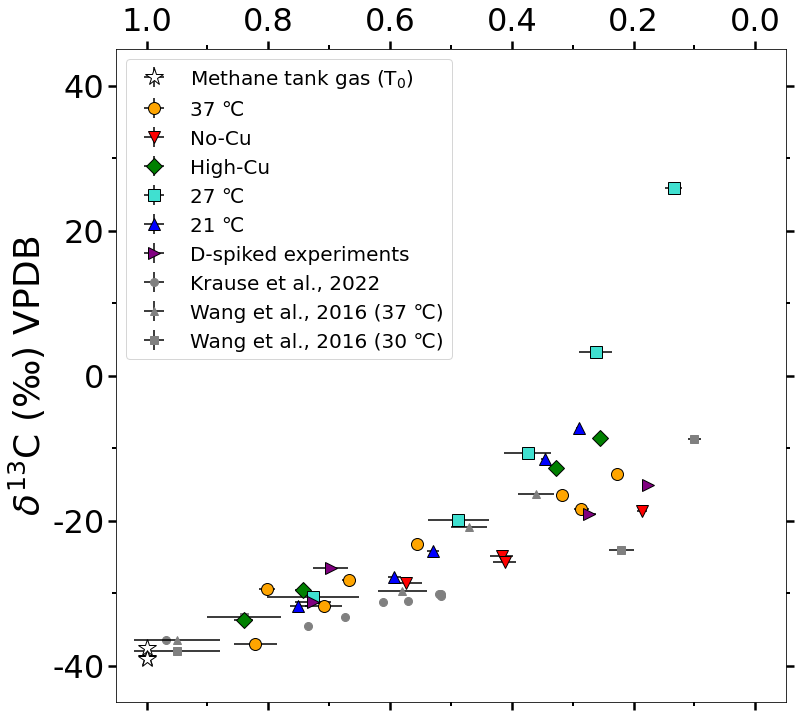

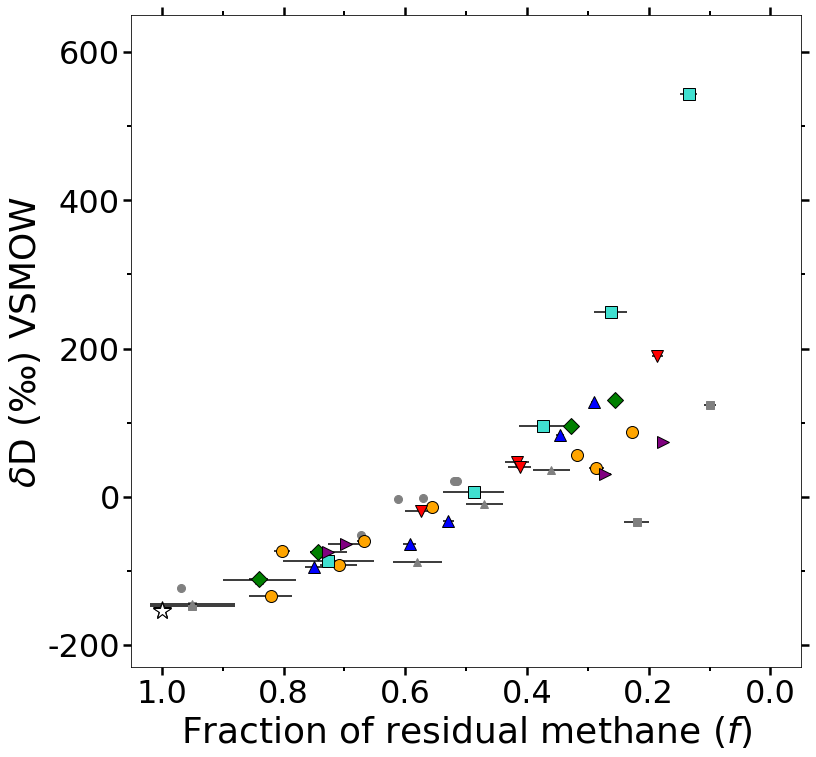

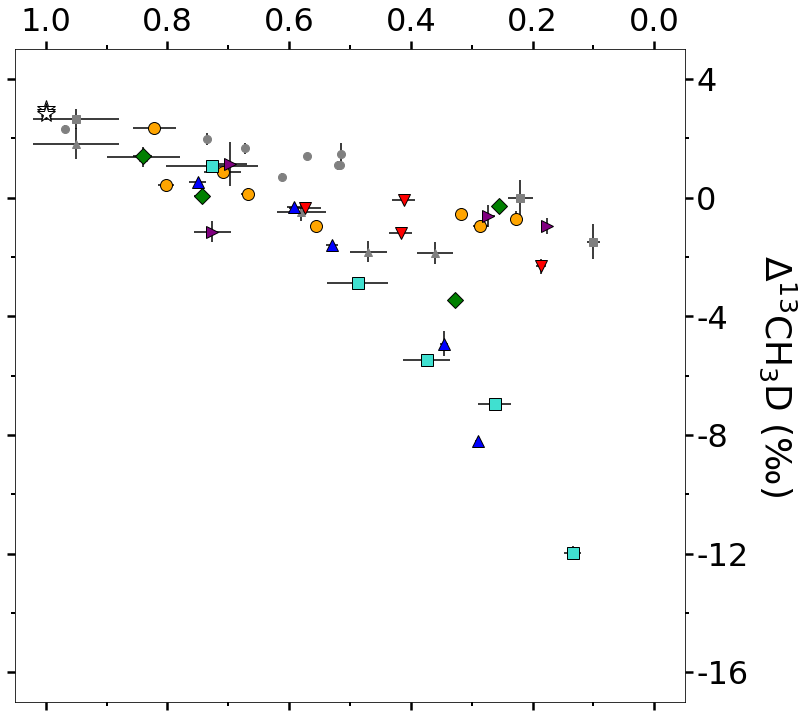

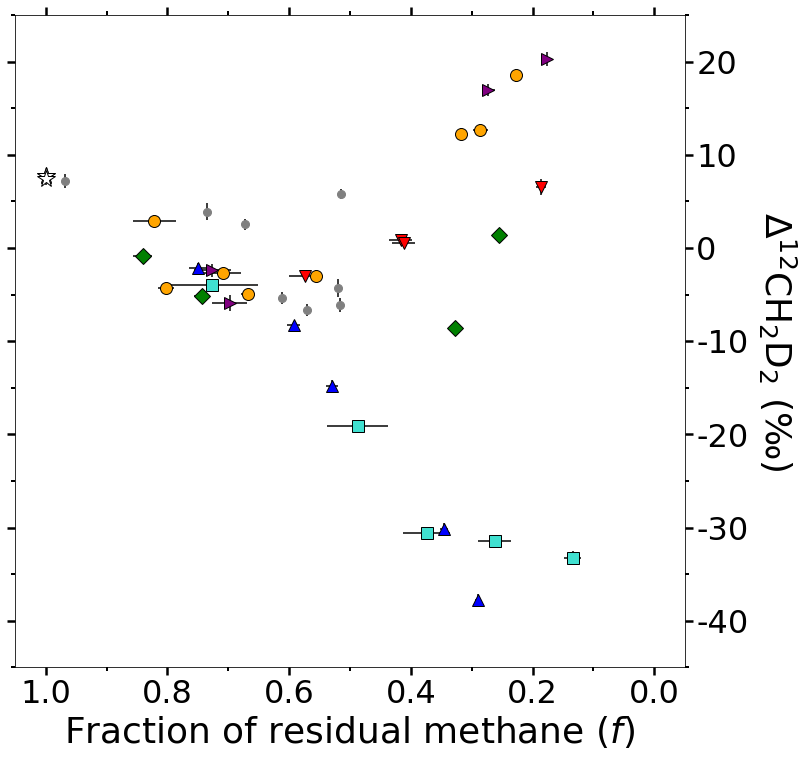

In [3]:
# Figure 2: isotope signatures vs. f
# d13C
# figure_f = plt.figure(figsize=(28,28))
fig13Cf, ax_13C_f=plt.subplots(figsize=(12,12))
ax_13C_f.errorbar(zero['f'],zero['d13C PDB'], xerr=zero['f 1 se'], yerr=zero['d13C 1 se'], fmt='*',
                    markerfacecolor='white',markeredgecolor='black',ecolor='black',markersize=18, 
                  label=r'Methane tank gas (T$_0$)' )
ax_13C_f.errorbar(Temp_37['f'],Temp_37['d13C PDB'], xerr=Temp_37['f 1 se'], yerr=Temp_37['d13C 1 se'], fmt='o',
                    markerfacecolor='orange',markeredgecolor='black', ecolor='black', markersize=12, 
                  label='37 \u2103' )
ax_13C_f.errorbar(Cu_free['f'],Cu_free['d13C PDB'], xerr=Cu_free['f 1 se'], yerr=Cu_free['d13C 1 se'], fmt='v',
                    markerfacecolor='red',markeredgecolor='black', ecolor='black', markersize=12, 
                  label='No-Cu' )
ax_13C_f.errorbar(High_Cu['f'],High_Cu['d13C PDB'], xerr=High_Cu['f 1 se'], yerr=High_Cu['d13C 1 se'], fmt='D',
                    markerfacecolor='green', markeredgecolor='black', ecolor='black', markersize=12, 
                  label='High-Cu' )
ax_13C_f.errorbar(Temp_27['f'],Temp_27['d13C PDB'], xerr=Temp_27['f 1 se'], yerr=Temp_27['d13C 1 se'], fmt='s',
                    markerfacecolor='turquoise', markeredgecolor='black', ecolor='black', markersize=12, 
                  label='27 \u2103' )
ax_13C_f.errorbar(Temp_21['f'],Temp_21['d13C PDB'], xerr=Temp_21['f 1 se'], yerr=Temp_21['d13C 1 se'], fmt='^',
                    markerfacecolor='blue', markeredgecolor='black', ecolor='black', markersize=12, 
                  label='21 \u2103' )
ax_13C_f.errorbar(D1500['f'],D1500['d13C PDB'], xerr=D1500['f 1 se'], yerr=D1500['d13C 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12, 
                  label='D-spiked experiments' )
ax_13C_f.errorbar(D3000['f'],D3000['d13C PDB'], xerr=D3000['f 1 se'], yerr=D3000['d13C 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12)
ax_13C_f.errorbar(krause['f'],krause['d13C PDB'], xerr=krause['f 1 se'], yerr=krause['d13C 1 se'], fmt='o',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=-2,label='Krause et al., 2022' )
ax_13C_f.errorbar(w37['f'],w37['d13C PDB'], xerr=w37['f 1 se'], yerr=w37['d13C 1 se'], fmt='^',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=0,label='Wang et al., 2016 (37 \u2103)' )
ax_13C_f.errorbar(w30['f'],w30['d13C PDB'], xerr=w30['f 1 se'], yerr=w30['d13C 1 se'], fmt='s',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=-1,label='Wang et al., 2016 (30 \u2103)' )
ax_13C_f.set_xlim([-0.05,1.05])
ax_13C_f.set_ylim([-45,45])
ax_13C_f.invert_xaxis()
ax_13C_f.set_ylabel('$\delta^{13}$C (\u2030) VPDB', fontdict=font_labels)
ax_13C_f.xaxis.set_major_locator(MultipleLocator(0.2))
ax_13C_f.xaxis.set_minor_locator(MultipleLocator(0.1))
ax_13C_f.yaxis.set_major_locator(MultipleLocator(20))
ax_13C_f.yaxis.set_minor_locator(MultipleLocator(10))
ax_13C_f.set_yticklabels(ax_13C_f.get_yticks(),fontdict=font_ticks)
ax_13C_f.set_xticklabels(ax_13C_f.get_xticks(),fontdict=font_ticks)
ax_13C_f.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_13C_f.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_13C_f.tick_params(which='major',direction='out', top=True, right=True, 
                     labeltop=True,labelbottom=False, length=8, width=2.5)
ax_13C_f.tick_params(which='minor',direction='out', top=True, right=True, length=4, width=2.0)
ax_13C_f.legend(fontsize=20)
# dD
figDf, ax_D_f=plt.subplots(figsize=(12,12))
ax_D_f.errorbar(zero['f'],zero['dD SMOW'], xerr=zero['f 1 se'], yerr=zero['dD 1 se'], fmt='*',
                    markerfacecolor='white',markeredgecolor='black', ecolor='black', markersize=18, label='Methane tank gas (T0)'  )
ax_D_f.errorbar(Temp_37['f'],Temp_37['dD SMOW'], xerr=Temp_37['f 1 se'], yerr=Temp_37['dD 1 se'], fmt='o',
                    markerfacecolor='orange', markeredgecolor='black', ecolor='black', markersize=12, label='37\u2103' )
ax_D_f.errorbar(Cu_free['f'],Cu_free['dD SMOW'], xerr=Cu_free['f 1 se'], yerr=Cu_free['dD 1 se'], fmt='v',
                    markerfacecolor='red', markeredgecolor='black', ecolor='black', markersize=12, label='37\u2103/0uM' )
ax_D_f.errorbar(High_Cu['f'],High_Cu['dD SMOW'], xerr=High_Cu['f 1 se'], yerr=High_Cu['dD 1 se'], fmt='D',
                    markerfacecolor='green', markeredgecolor='black', ecolor='black', markersize=12, label='37\u2103/50uM' )
ax_D_f.errorbar(Temp_27['f'],Temp_27['dD SMOW'], xerr=Temp_27['f 1 se'], yerr=Temp_27['dD 1 se'], fmt='s',
                    markerfacecolor='turquoise', markeredgecolor='black', ecolor='black', markersize=12, label='27\u2103/5uM' )
ax_D_f.errorbar(Temp_21['f'],Temp_21['dD SMOW'], xerr=Temp_21['f 1 se'], yerr=Temp_21['dD 1 se'], fmt='^',
                    markerfacecolor='blue', markeredgecolor='black', ecolor='black', markersize=12, label='21\u2103/5uM' )
ax_D_f.errorbar(D1500['f'],D1500['dD SMOW'], xerr=D1500['f 1 se'], yerr=D1500['dD 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12, label='D-spiked experiments' )
ax_D_f.errorbar(D3000['f'],D3000['dD SMOW'], xerr=D3000['f 1 se'], yerr=D3000['dD 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12)
ax_D_f.errorbar(krause['f'],krause['dD SMOW'], xerr=krause['f 1 se'], yerr=krause['dD 1 se'], fmt='o',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                zorder=-2, label='Krause et al., 2022' )
ax_D_f.errorbar(w37['f'],w37['dD SMOW'], xerr=w37['f 1 se'], yerr=w37['dD 1 se'], fmt='^',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=0, label='Wang et al., 2016 (37 \u2103)' )
ax_D_f.errorbar(w30['f'],w30['dD SMOW'], xerr=w30['f 1 se'], yerr=w30['dD 1 se'], fmt='s',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=-1, label='Wang et al., 2016 (30 \u2103)' )
ax_D_f.set_xlim([-0.05,1.05])
ax_D_f.set_ylim([-230,650])
ax_D_f.invert_xaxis()
ax_D_f.set_ylabel('$\delta$D (\u2030) VSMOW', fontdict=font_labels)
ax_D_f.set_xlabel('Fraction of residual methane ($f$)', fontdict=font_labels)
ax_D_f.xaxis.set_major_locator(MultipleLocator(0.2))
ax_D_f.xaxis.set_minor_locator(MultipleLocator(0.1))
ax_D_f.yaxis.set_major_locator(MultipleLocator(200))
ax_D_f.yaxis.set_minor_locator(MultipleLocator(100))
ax_D_f.set_yticklabels(ax_D_f.get_yticks(),fontdict=font_ticks)
ax_D_f.set_xticklabels(ax_D_f.get_xticks(),fontdict=font_ticks)
ax_D_f.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_D_f.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_D_f.tick_params(which='major',direction='out', top=True, right=True,length=8, width=2.5)
ax_D_f.tick_params(which='minor',direction='out', top=True, right=True,length=4, width=2.0)
# D13CH3D
fig13CDf, ax_13CD_f=plt.subplots(figsize=(12,12))
ax_13CD_f.errorbar(zero['f'],zero['D13CH3D'], xerr=zero['f 1 se'], yerr=zero['D13CH3D 1 se'], fmt='*',
                    markerfacecolor='white',markeredgecolor='black',ecolor='black', markersize=18, label='Methane tank gas (T0)'  )
ax_13CD_f.errorbar(Temp_37['f'],Temp_37['D13CH3D'], xerr=Temp_37['f 1 se'], yerr=Temp_37['D13CH3D 1 se'], fmt='o',
                    markerfacecolor='orange', markeredgecolor='black',ecolor='black', markersize=12, label='37\u2103' )
ax_13CD_f.errorbar(Cu_free['f'],Cu_free['D13CH3D'], xerr=Cu_free['f 1 se'], yerr=Cu_free['D13CH3D 1 se'], fmt='v',
                    markerfacecolor='red',markeredgecolor='black',ecolor='black', markersize=12, label='37\u2103/0uM' )
ax_13CD_f.errorbar(High_Cu['f'],High_Cu['D13CH3D'], xerr=High_Cu['f 1 se'], yerr=High_Cu['D13CH3D 1 se'], fmt='D',
                    markerfacecolor='green',markeredgecolor='black',ecolor='black', markersize=12, label='37\u2103/50uM' )
ax_13CD_f.errorbar(Temp_27['f'],Temp_27['D13CH3D'], xerr=Temp_27['f 1 se'], yerr=Temp_27['D13CH3D 1 se'], fmt='s',
                    markerfacecolor='turquoise', markeredgecolor='black',ecolor='black', markersize=12, label='27\u2103/5uM' )
ax_13CD_f.errorbar(Temp_21['f'],Temp_21['D13CH3D'], xerr=Temp_21['f 1 se'], yerr=Temp_21['D13CH3D 1 se'], fmt='^',
                    markerfacecolor='blue', markeredgecolor='black',ecolor='black', markersize=12, label='21\u2103/5uM' )
ax_13CD_f.errorbar(D1500['f'],D1500['D13CH3D'], xerr=D1500['f 1 se'], yerr=D1500['D13CH3D 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12, label='D-spiked experiments' )
ax_13CD_f.errorbar(D3000['f'],D3000['D13CH3D'], xerr=D3000['f 1 se'], yerr=D3000['D13CH3D 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12)
ax_13CD_f.errorbar(krause['f'],krause['D13CH3D'], xerr=krause['f 1 se'], yerr=krause['D13CH3D 1 se'], fmt='o',
                    zorder=-2, markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, label='Krause et al., 2022' )
ax_13CD_f.errorbar(w37['f'],w37['D13CH3D'], xerr=w37['f 1 se'], yerr=w37['D13CH3D 1 se'], fmt='^',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=0, label='Wang et al., 2016 (37 \u2103)' )
ax_13CD_f.errorbar(w30['f'],w30['D13CH3D'], xerr=w30['f 1 se'], yerr=w30['D13CH3D 1 se'], fmt='s',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, 
                  zorder=-1, label='Wang et al., 2016 (30 \u2103)' )
ax_13CD_f.set_xlim([-0.05,1.05])
ax_13CD_f.set_ylim([-17,5])
ax_13CD_f.invert_xaxis()
ax_13CD_f.set_ylabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict=font_labels, rotation=270, labelpad=50)
ax_13CD_f.yaxis.set_label_position("right")
ax_13CD_f.xaxis.set_major_locator(MultipleLocator(0.2))
ax_13CD_f.xaxis.set_minor_locator(MultipleLocator(0.1))
ax_13CD_f.yaxis.set_major_locator(MultipleLocator(4))
ax_13CD_f.yaxis.set_minor_locator(MultipleLocator(2))
ax_13CD_f.set_yticklabels(ax_13CD_f.get_yticks(),fontdict=font_ticks)
ax_13CD_f.set_xticklabels(ax_13CD_f.get_xticks(),fontdict=font_ticks)
ax_13CD_f.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_13CD_f.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_13CD_f.tick_params(which='major',direction='out', top=True, right=True, labeltop=True, labelright=True, 
                      labelleft=False, labelbottom=False, length=8, width=2.5)
ax_13CD_f.tick_params(which='minor',direction='out', top=True, right=True, length=4, width=2.0)
# D12CH2D2
figDDf, ax_DD_f=plt.subplots(figsize=(12,12))
ax_DD_f.errorbar(zero['f'],zero['D12CH2D2'], xerr=zero['f 1 se'], yerr=zero['D12CH2D2 1 se'], fmt='*',
                    markerfacecolor='white',markeredgecolor='black', ecolor='black', markersize=18, label='Methane tank gas (T0)')
ax_DD_f.errorbar(Temp_37['f'],Temp_37['D12CH2D2'], xerr=Temp_37['f 1 se'], yerr=Temp_37['D12CH2D2 1 se'], fmt='o',
                    markerfacecolor='orange',markeredgecolor='black', ecolor='black', markersize=12, label='37\u2103' )
ax_DD_f.errorbar(Cu_free['f'],Cu_free['D12CH2D2'], xerr=Cu_free['f 1 se'], yerr=Cu_free['D12CH2D2 1 se'], fmt='v',
                    markerfacecolor='red', markeredgecolor='black', ecolor='black', markersize=12, label='37\u2103/0uM' )
ax_DD_f.errorbar(High_Cu['f'],High_Cu['D12CH2D2'], xerr=High_Cu['f 1 se'], yerr=High_Cu['D12CH2D2 1 se'], fmt='D',
                    markerfacecolor='green', markeredgecolor='black', ecolor='black', markersize=12, label='37\u2103/50uM' )
ax_DD_f.errorbar(Temp_27['f'],Temp_27['D12CH2D2'], xerr=Temp_27['f 1 se'], yerr=Temp_27['D12CH2D2 1 se'], fmt='s',
                    markerfacecolor='turquoise', markeredgecolor='black', ecolor='black', markersize=12, label='27\u2103/5uM' )
ax_DD_f.errorbar(Temp_21['f'],Temp_21['D12CH2D2'], xerr=Temp_21['f 1 se'], yerr=Temp_21['D12CH2D2 1 se'], fmt='^',
                    markerfacecolor='blue', markeredgecolor='black', ecolor='black', markersize=12, label='21\u2103/5uM' )
ax_DD_f.errorbar(D1500['f'],D1500['D12CH2D2'], xerr=D1500['f 1 se'], yerr=D1500['D12CH2D2 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12, label='D-spiked experiments' )
ax_DD_f.errorbar(D3000['f'],D3000['D12CH2D2'], xerr=D3000['f 1 se'], yerr=D3000['D12CH2D2 1 se'], fmt='>',
                    markerfacecolor='purple', markeredgecolor='black', ecolor='black', markersize=12)
ax_DD_f.errorbar(krause['f'],krause['D12CH2D2'], xerr=krause['f 1 se'], yerr=krause['D12CH2D2 1 se'], fmt='o',
                    markerfacecolor='grey', markeredgecolor='grey', ecolor='black', markersize=8, label='Krause et al., 2022' )
ax_DD_f.set_xlim([-0.05,1.05])
ax_DD_f.set_ylim([-45,25])
ax_DD_f.invert_xaxis()
ax_DD_f.set_xlabel('Fraction of residual methane ($f$)', fontdict=font_labels)
ax_DD_f.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict=font_labels, rotation=270, labelpad=50)
ax_DD_f.yaxis.set_label_position("right")
ax_DD_f.xaxis.set_major_locator(MultipleLocator(0.2))
ax_DD_f.xaxis.set_minor_locator(MultipleLocator(0.1))
ax_DD_f.yaxis.set_major_locator(MultipleLocator(10))
ax_DD_f.yaxis.set_minor_locator(MultipleLocator(5))
ax_DD_f.set_yticklabels(ax_DD_f.get_yticks(),fontdict=font_ticks)
ax_DD_f.set_xticklabels(ax_DD_f.get_xticks(),fontdict=font_ticks)
ax_DD_f.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_DD_f.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_DD_f.tick_params(which='major',direction='out', top=True, right=True,
                    labelleft=False, labelright=True, length=8, width=2.5)
ax_DD_f.tick_params(which='minor',direction='out', top=True, right=True,length=4, width=2.0)
fig13Cf.savefig('Cf.pdf',bbox_inches = 'tight')
figDf.savefig('Df.pdf',bbox_inches = 'tight')
fig13CDf.savefig('CDf.pdf',bbox_inches = 'tight')
figDDf.savefig('DDf.pdf',bbox_inches = 'tight')
plt.show()

 Temperature      alpha_H          1se      alpha_C          1se   alpha_13CD          1se     alpha_D2          1se
   37C 5uM/H       0.6967       0.0101       0.9671       0.0011       0.6716       0.0110       0.4309       0.0193
     18.8725      16.7219      16.8434      16.5085
   37C 5uM/L       0.8892       0.0028       0.9887       0.0003       0.8775       0.0031       0.7542       0.0064
     20.5026      18.5018      19.0684      16.2727
   27C 5uM H       0.7452       0.0209       0.9713       0.0024       0.7249       0.0227       0.5291       0.0387
      0.1016       0.1271       0.1221       0.1357
   27C 5uM L       0.6683       0.0466       0.9649       0.0049       0.6396       0.0507       0.3392       0.0929
      0.1019       0.0896       0.1048       0.0905
     21C 5uM       0.7742       0.0022       0.9757       0.0002       0.7580       0.0024       0.5841       0.0043
     15.9899       7.8886       8.2072       8.0533


<ipython-input-4-f545f56c57c0>:162: UserWarning: FixedFormatter should only be used together with FixedLocator
  axC_NY.set_yticklabels(axC_NY.get_yticks(),fontdict=font_ticks)
<ipython-input-4-f545f56c57c0>:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  axC_NY.set_xticklabels(axC_NY.get_xticks(),fontdict=font_ticks)
<ipython-input-4-f545f56c57c0>:175: UserWarning: FixedFormatter should only be used together with FixedLocator
  axH_NY.set_yticklabels(axH_NY.get_yticks(),fontdict=font_ticks)
<ipython-input-4-f545f56c57c0>:176: UserWarning: FixedFormatter should only be used together with FixedLocator
  axH_NY.set_xticklabels(axH_NY.get_xticks(),fontdict=font_ticks)
<ipython-input-4-f545f56c57c0>:199: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_13CD_NY.set_yticklabels(ax_13CD_NY.get_yticks(),fontdict=font_ticks)
<ipython-input-4-f545f56c57c0>:200: UserWarning: FixedFormatter should only be used together with FixedLoca

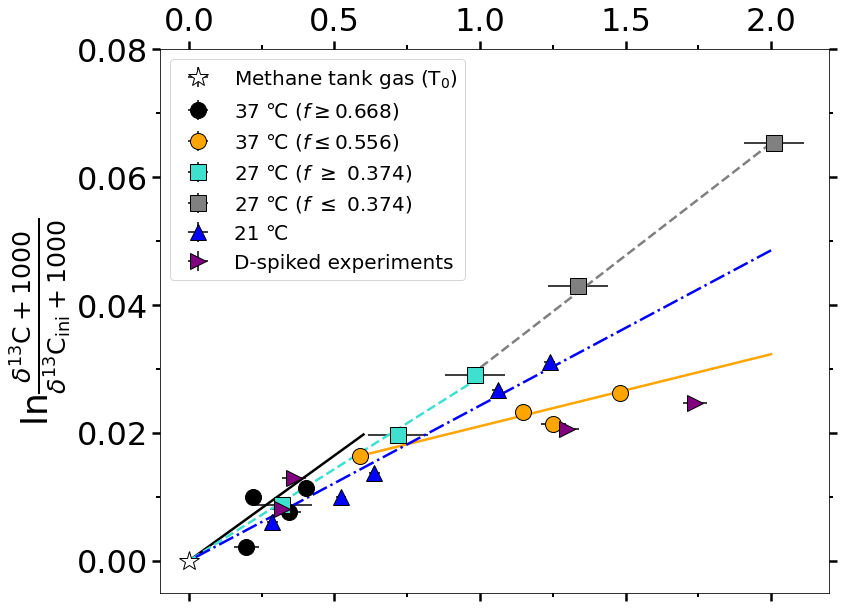

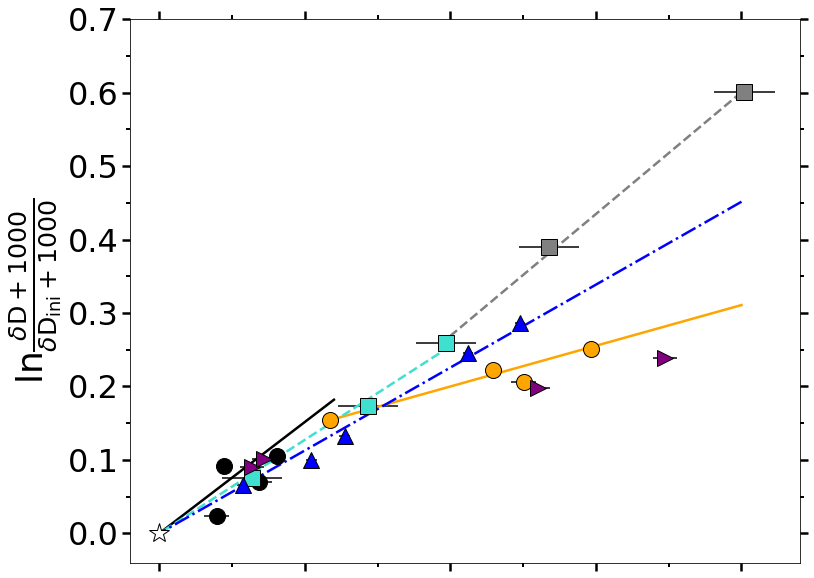

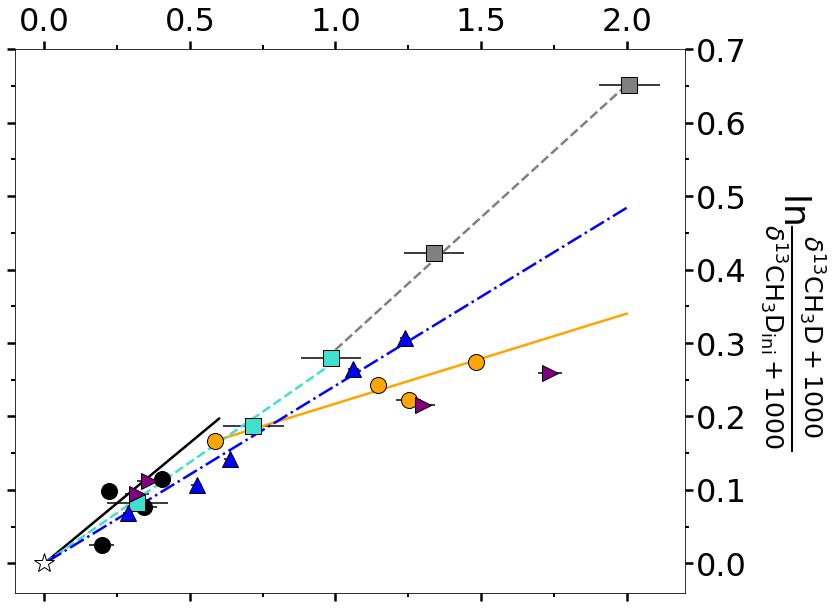

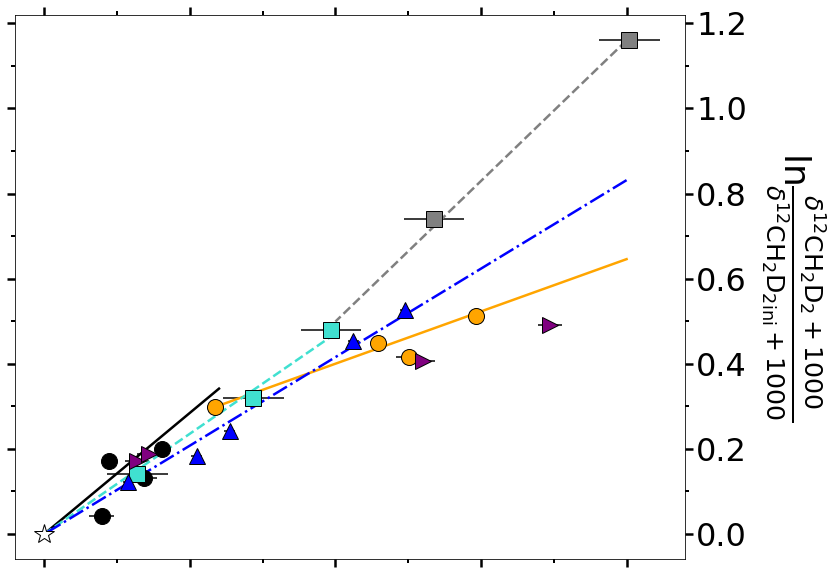

In [4]:
figC_NY,axC_NY=plt.subplots(figsize=(12,10))
figH_NY,axH_NY=plt.subplots(figsize=(12,10))
fig_13CD_NY,ax_13CD_NY=plt.subplots(figsize=(12,10))
fig_D2_NY,ax_D2_NY=plt.subplots(figsize=(12,10))
logf_plot=-np.linspace(-2,0,11)  
# Plot zeros
axC_NY.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label=r"Methane tank gas (T$_0$)")
axH_NY.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label="Methane tank gas (T0)")
ax_13CD_NY.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label="Methane tank gas (T0)")
ax_D2_NY.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label="Methane tank gas (T0)")
# Read the data
rayleigh_data = pd.ExcelFile('data_table.xlsx')
rle37_1  = rayleigh_data.parse('37C_1')
rle37_2  = rayleigh_data.parse('37C_2')
rle27  = rayleigh_data.parse('27C')
rle27o  = rayleigh_data.parse('27o')
rle21 = rayleigh_data.parse('21C')
Dspike = rayleigh_data.parse('Dspike')
# Calculate slopes and intercepts, and plot
print('%12s %12s %12s %12s %12s %12s %12s %12s %12s'%('Temperature', 'alpha_H','1se','alpha_C','1se','alpha_13CD','1se','alpha_D2','1se'))
# ---------------------------------------------------------------------
# 37C H
c="black"
mt="o"
dt=rle37_1
dtlabel="37 \u2103 ($f$$\geq$0.668)"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "37C 5uM/H")
axC_NY.errorbar(dt['lnf'].iloc[1:],dt['rC'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rC 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_NY.errorbar(dt['lnf'].iloc[1:],dt['rH'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rH 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_13CD_NY.errorbar(dt['lnf'].iloc[1:],dt['r13CD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["r13CD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_D2_NY.errorbar(dt['lnf'].iloc[1:],dt['rDD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rDD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[7:]+intercept_C
H_plot=slope_H*logf_plot[7:]+intercept_H
axC_NY.plot(logf_plot[7:],C_plot,'-',linewidth=2.5,color=c)
axH_NY.plot(logf_plot[7:],H_plot,'-',linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[7:]+intercept_13CD
D2_plot=slope_D2*logf_plot[7:]+intercept_D2
ax_13CD_NY.plot(logf_plot[7:],CD_plot,'-',color=c,linewidth=2.5)
ax_D2_NY.plot(logf_plot[7:],D2_plot,'-',color=c,linewidth=2.5)
# ---------------------------------------------------------------------
# 37C L
c="orange"
mt="o"
dt=rle37_2
dtlabel="37 \u2103 ($f$$\leq$0.556)"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "37C 5uM/L")
axC_NY.errorbar(dt['lnf'].iloc[0:],dt['rC'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rC 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_NY.errorbar(dt['lnf'].iloc[0:],dt['rH'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rH 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_13CD_NY.errorbar(dt['lnf'].iloc[0:],dt['r13CD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["r13CD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_D2_NY.errorbar(dt['lnf'].iloc[0:],dt['rDD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rDD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[:8]+intercept_C
H_plot=slope_H*logf_plot[:8]+intercept_H
axC_NY.plot(logf_plot[:8],C_plot,'-',linewidth=2.5,color=c)
axH_NY.plot(logf_plot[:8],H_plot,'-',linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[:8]+intercept_13CD
D2_plot=slope_D2*logf_plot[:8]+intercept_D2
ax_13CD_NY.plot(logf_plot[:8],CD_plot,'-',color=c, linewidth=2.5)
ax_D2_NY.plot(logf_plot[:8],D2_plot,'-',color=c, linewidth=2.5)
# ---------------------------------------------------------------------
# 27C
c="turquoise"
mt="s"
dt=rle27
dtlabel="27 \u2103 ($f\ \geq$ 0.374)"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "27C 5uM H")
axC_NY.errorbar(dt['lnf'].iloc[1:],dt['rC'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rC 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_NY.errorbar(dt['lnf'].iloc[1:],dt['rH'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rH 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_13CD_NY.errorbar(dt['lnf'].iloc[1:],dt['r13CD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["r13CD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_D2_NY.errorbar(dt['lnf'].iloc[1:],dt['rDD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rDD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[5:]+intercept_C
H_plot=slope_H*logf_plot[5:]+intercept_H
axC_NY.plot(logf_plot[5:],C_plot,'--', linewidth=2.5,color=c)
axH_NY.plot(logf_plot[5:],H_plot,'--', linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[5:]+intercept_13CD
D2_plot=slope_D2*logf_plot[5:]+intercept_D2
ax_13CD_NY.plot(logf_plot[5:],CD_plot,'--',color=c, linewidth=2.5)
ax_D2_NY.plot(logf_plot[5:],D2_plot,'--',color=c, linewidth=2.5)
# ---------------------------------------------------------------------
# 27C outlier 
c="gray"
mt="s"
dt=rle27o
dtlabel="27 \u2103 ($f\ \leq$ 0.374)"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "27C 5uM L")
axC_NY.errorbar(dt['lnf'].iloc[0:2],dt['rC'].iloc[0:2],xerr=dt["lnf 1 se"].iloc[0:2], yerr=dt["rC 1 se"].iloc[0:2],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_NY.errorbar(dt['lnf'].iloc[0:2],dt['rH'].iloc[0:2],xerr=dt["lnf 1 se"].iloc[0:2], yerr=dt["rH 1 se"].iloc[0:2],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_13CD_NY.errorbar(dt['lnf'].iloc[0:2],dt['r13CD'].iloc[0:2],xerr=dt["lnf 1 se"].iloc[0:2], yerr=dt["r13CD 1 se"].iloc[0:2],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_D2_NY.errorbar(dt['lnf'].iloc[0:2],dt['rDD'].iloc[0:2],xerr=dt["lnf 1 se"].iloc[0:2], yerr=dt["rDD 1 se"].iloc[0:2],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[:6]+intercept_C
H_plot=slope_H*logf_plot[:6]+intercept_H
axC_NY.plot(logf_plot[:6],C_plot,'--', linewidth=2.5,color=c)
axH_NY.plot(logf_plot[:6],H_plot,'--', linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[:6]+intercept_13CD
D2_plot=slope_D2*logf_plot[:6]+intercept_D2
ax_13CD_NY.plot(logf_plot[:6],CD_plot,'--',color=c, linewidth=2.5)
ax_D2_NY.plot(logf_plot[:6],D2_plot,'--',color=c, linewidth=2.5)
# ---------------------------------------------------------------------
# 21C
c="blue"
mt="^"
dt=rle21
dtlabel="21 \u2103"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "21C 5uM")
axC_NY.errorbar(dt['lnf'].iloc[1:],dt['rC'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rC 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_NY.errorbar(dt['lnf'].iloc[1:],dt['rH'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rH 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_13CD_NY.errorbar(dt['lnf'].iloc[1:],dt['r13CD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["r13CD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_D2_NY.errorbar(dt['lnf'].iloc[1:],dt['rDD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rDD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot+intercept_C
H_plot=slope_H*logf_plot+intercept_H
axC_NY.plot(logf_plot,C_plot,'-.', linewidth=2.5,color=c)
axH_NY.plot(logf_plot,H_plot,'-.', linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot+intercept_13CD
D2_plot=slope_D2*logf_plot+intercept_D2
ax_13CD_NY.plot(logf_plot,CD_plot,'-.',color=c, linewidth=2.5)
ax_D2_NY.plot(logf_plot,D2_plot,'-.',color=c, linewidth=2.5)
# ---------------------------------------------------------------------
# D-spiked experiments
c="purple"
mt=">"
dt=Dspike
dtlabel="D-spiked experiments"
axC_NY.errorbar(dt['lnf'].iloc[1:],dt['rC'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rC 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_NY.errorbar(dt['lnf'].iloc[1:],dt['rH'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rH 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_13CD_NY.errorbar(dt['lnf'].iloc[1:],dt['r13CD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["r13CD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
ax_D2_NY.errorbar(dt['lnf'].iloc[1:],dt['rDD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rDD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)

axC_NY.set_ylabel(r'ln$\frac{\delta {\rm ^{13}C}+1000}{\delta {\rm ^{13}C_{ini}}+1000}$',fontdict=font_labels)
axH_NY.set_ylabel(r'ln$\frac{\delta {\rm D}+1000}{\delta {\rm D_{ini}}+1000}$',fontdict=font_labels)
axC_NY.set_xlim([-0.1,2.2])
axC_NY.set_ylim([-0.005,0.08])
axC_NY.xaxis.set_minor_locator(MultipleLocator(0.25))
axC_NY.yaxis.set_major_locator(MultipleLocator(0.02))
axC_NY.yaxis.set_minor_locator(MultipleLocator(0.01))
axC_NY.set_yticklabels(axC_NY.get_yticks(),fontdict=font_ticks)
axC_NY.set_xticklabels(axC_NY.get_xticks(),fontdict=font_ticks)
axC_NY.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axC_NY.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axC_NY.tick_params(which='major',direction='out', length=8, width=2.5, 
                   top=True, right=True, labeltop=True, labelbottom=False)
axC_NY.tick_params(which='minor',direction='out', length=4, width=2.0,
                  top=True, right=True)
axH_NY.set_xlim([-0.1,2.2])
axH_NY.set_ylim([-0.04,0.7])
axH_NY.xaxis.set_minor_locator(MultipleLocator(0.25))
axH_NY.yaxis.set_major_locator(MultipleLocator(0.1))
axH_NY.yaxis.set_minor_locator(MultipleLocator(0.05))
axH_NY.set_yticklabels(axH_NY.get_yticks(),fontdict=font_ticks)
axH_NY.set_xticklabels(axH_NY.get_xticks(),fontdict=font_ticks)
axH_NY.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axH_NY.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axH_NY.tick_params(which='major',direction='out', length=8, width=2.5, 
                   top=True, right=True, labelbottom=False)
axH_NY.tick_params(which='minor',direction='out', length=4, width=2.0,
                  top=True, right=True)

ax_13CD_NY.set_ylabel(r'ln$\frac{\delta {\rm ^{13}CH_3D}+1000}{\delta {\rm ^{13}CH_3D_{ini}}+1000}$',
                      fontdict=font_labels, rotation=270, labelpad=80)
ax_13CD_NY.yaxis.set_label_position("right")
#ax_13CD.set_title(r'Regression for $^{13CD}\alpha$',fontdict=font)
#ax_13CD_NY.set_xlabel('-ln$f$',fontdict=font_labels)
#ax_D2_NY.set_xlabel('-ln$f$',fontdict=font_labels)
ax_D2_NY.set_ylabel(r'ln$\frac{\delta {\rm ^{12}CH_2D_2}+1000}{\delta {\rm ^{12}CH_2D_{2 ini}}+1000}$',
                    fontdict=font_labels, rotation=270, labelpad=80)
ax_D2_NY.yaxis.set_label_position("right")
#ax_D2.set_title(r'Regression for $^{D2}\alpha$',fontdict=font)
ax_13CD_NY.set_xlim([-0.1,2.2])
ax_13CD_NY.set_ylim([-0.04,0.7])
ax_13CD_NY.xaxis.set_minor_locator(MultipleLocator(0.25))
ax_13CD_NY.yaxis.set_major_locator(MultipleLocator(0.1))
ax_13CD_NY.yaxis.set_minor_locator(MultipleLocator(0.05))
ax_13CD_NY.set_yticklabels(ax_13CD_NY.get_yticks(),fontdict=font_ticks)
ax_13CD_NY.set_xticklabels(ax_13CD_NY.get_xticks(),fontdict=font_ticks)
ax_13CD_NY.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_13CD_NY.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_13CD_NY.tick_params(which='major',direction='out', length=8, width=2.5, 
                       top=True, right=True, labelleft=False, labelright=True, labelbottom=False, labeltop=True)
ax_13CD_NY.tick_params(which='minor',direction='out', length=4, width=2.0,
                      top=True, right=True)

ax_D2_NY.set_xlim([-0.1,2.2])
ax_D2_NY.xaxis.set_minor_locator(MultipleLocator(0.25))
ax_D2_NY.yaxis.set_major_locator(MultipleLocator(0.2))
ax_D2_NY.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_D2_NY.set_yticklabels(ax_D2_NY.get_yticks(),fontdict=font_ticks)
ax_D2_NY.set_xticklabels(ax_D2_NY.get_xticks(),fontdict=font_ticks)
ax_D2_NY.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_D2_NY.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_D2_NY.tick_params(which='major',direction='out', length=8, width=2.5,
                    top=True, right=True, labelbottom=False, labelleft=False, labelright=True)
ax_D2_NY.tick_params(which='minor',direction='out', length=4, width=2.0,
                    top=True, right=True)

axC_NY.legend(fontsize=20)
figC_NY.savefig('RC_NY.pdf',bbox_inches = 'tight')
figH_NY.savefig('RH_NY.pdf',bbox_inches = 'tight')
fig_13CD_NY.savefig('RCD_NY.pdf',bbox_inches = 'tight')
fig_D2_NY.savefig('RDD_NY.pdf',bbox_inches = 'tight')

plt.show()

 Temperature      alpha_H          1se      alpha_C          1se   alpha_13CD          1se     alpha_D2          1se
   37C 5uM/H       0.6967       0.0101       0.9671       0.0011       0.6716       0.0110       0.4309       0.0193
     18.8725      16.7219      16.8434      16.5085
   37C 5uM/L       0.8892       0.0028       0.9887       0.0003       0.8775       0.0031       0.7542       0.0064
     20.5026      18.5018      19.0684      16.2727
     37C 0uM       0.8304       0.0093       0.9911       0.0005       0.8234       0.0097       0.6526       0.0191
      1.8878       0.5332       0.5375       0.5597
    37C 50uM       0.7012       0.0161       0.9670       0.0018       0.6772       0.0175       0.4459       0.0303
      0.1197       0.1332       0.1184       0.2193


<ipython-input-5-4d78768598ad>:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  axC_Cu.set_yticklabels(axC_NY.get_yticks(),fontdict=font_ticks)
<ipython-input-5-4d78768598ad>:150: UserWarning: FixedFormatter should only be used together with FixedLocator
  axC_Cu.set_xticklabels(axC_NY.get_xticks(),fontdict=font_ticks)
<ipython-input-5-4d78768598ad>:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  axH_Cu.set_yticklabels(axH_NY.get_yticks(),fontdict=font_ticks)
<ipython-input-5-4d78768598ad>:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  axH_Cu.set_xticklabels(axH_NY.get_xticks(),fontdict=font_ticks)
<ipython-input-5-4d78768598ad>:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  axCD_Cu.set_yticklabels(axCD_Cu.get_yticks(),fontdict=font_ticks)
<ipython-input-5-4d78768598ad>:189: UserWarning: FixedFormatter should only be used together with FixedLocator
  

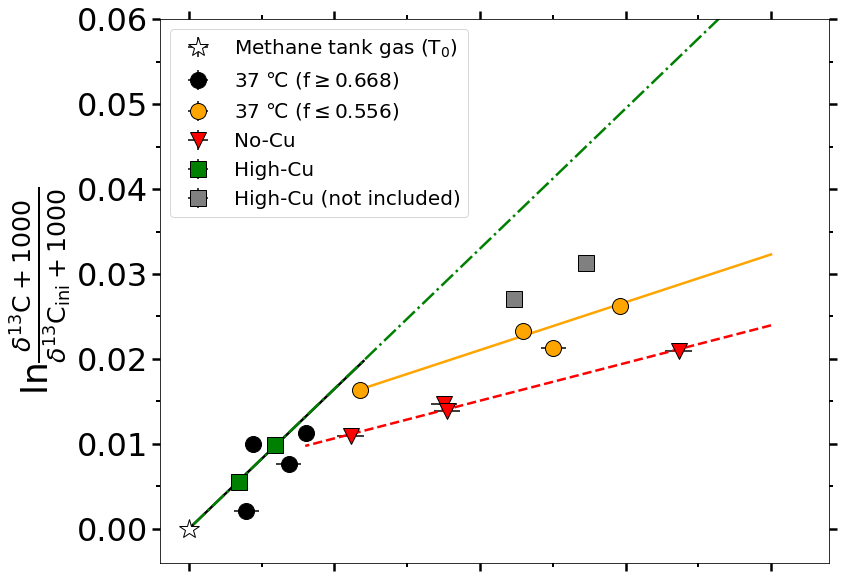

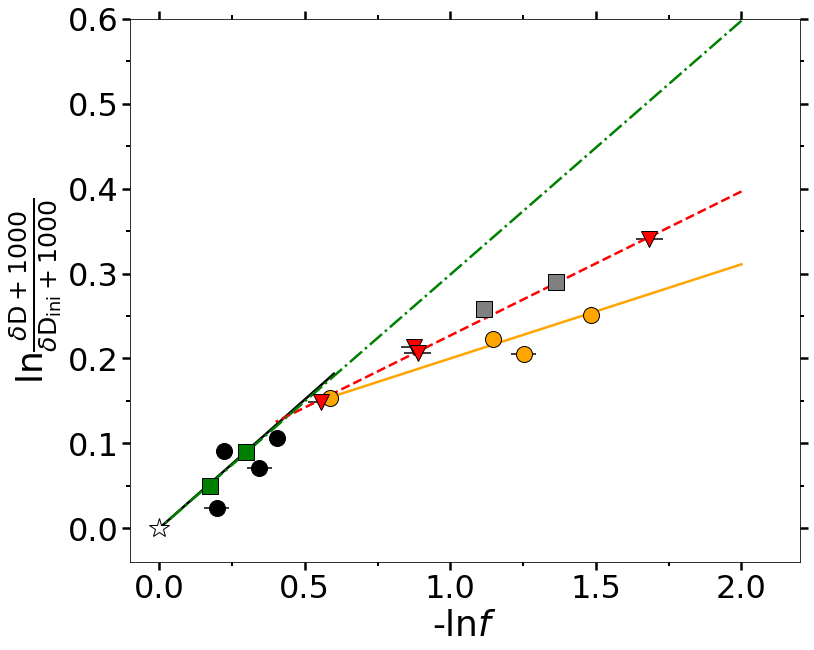

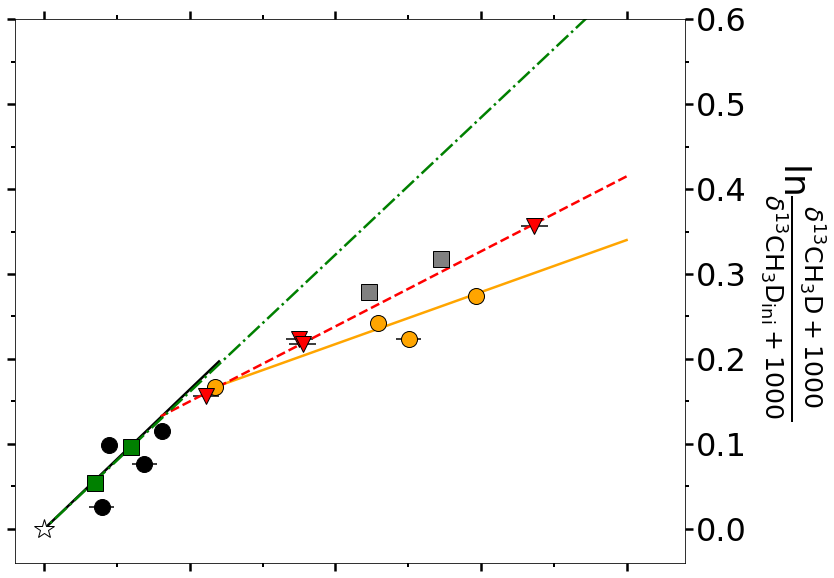

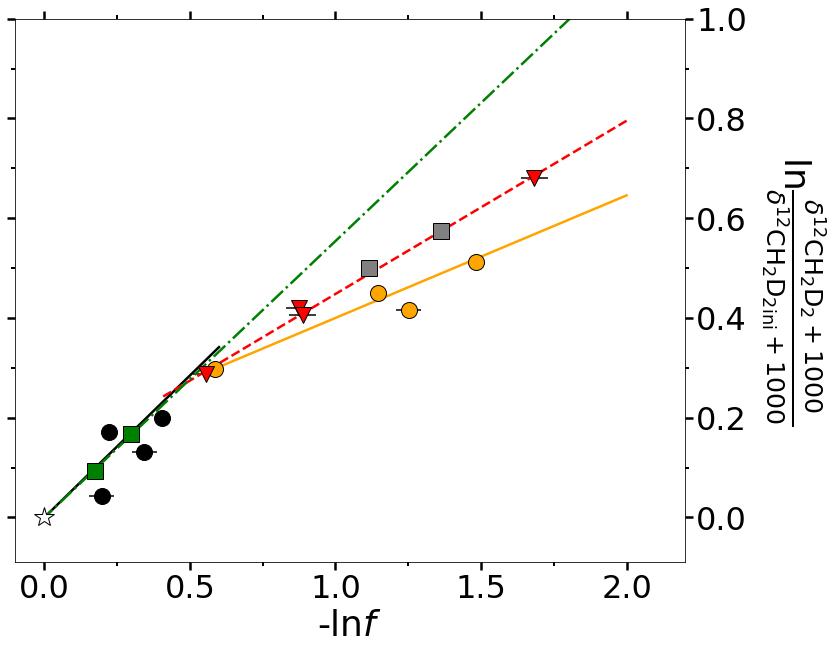

In [5]:
# bulk copper
print('%12s %12s %12s %12s %12s %12s %12s %12s %12s'%('Temperature', 'alpha_H','1se','alpha_C','1se','alpha_13CD','1se','alpha_D2','1se'))
figC_Cu,axC_Cu=plt.subplots(figsize=(12,10))
figH_Cu,axH_Cu=plt.subplots(figsize=(12,10))
figCD_Cu,axCD_Cu=plt.subplots(figsize=(12,10))
figDD_Cu,axDD_Cu=plt.subplots(figsize=(12,10))

rle0Cu  = rayleigh_data.parse('0Cu')
rle50Cu  = rayleigh_data.parse('50Cu')

# Plot zeros
axC_Cu.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label=r"Methane tank gas (T$_0$)")
axH_Cu.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label="Methane tank gas (T0)")
axCD_Cu.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label="Methane tank gas (T0)")
axDD_Cu.errorbar(0,0,xerr=0,yerr=0,fmt="*",markerfacecolor='white',markeredgecolor='black',markersize=20, ecolor='black',
            label="Methane tank gas (T0)")

# 37C H
c="black"
mt="o"
dt=rle37_1
dtlabel="37 \u2103 (f$\geq$0.668)"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "37C 5uM/H")
axC_Cu.errorbar(dt['lnf'].iloc[1:],dt['rC'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rC 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_Cu.errorbar(dt['lnf'].iloc[1:],dt['rH'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rH 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axCD_Cu.errorbar(dt['lnf'].iloc[1:],dt['r13CD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["r13CD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axDD_Cu.errorbar(dt['lnf'].iloc[1:],dt['rDD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rDD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[7:]+intercept_C
H_plot=slope_H*logf_plot[7:]+intercept_H
axC_Cu.plot(logf_plot[7:],C_plot,'-',linewidth=2.5,color=c)
axH_Cu.plot(logf_plot[7:],H_plot,'-',linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[7:]+intercept_13CD
D2_plot=slope_D2*logf_plot[7:]+intercept_D2
axCD_Cu.plot(logf_plot[7:],CD_plot,'-',color=c,linewidth=2.5)
axDD_Cu.plot(logf_plot[7:],D2_plot,'-',color=c,linewidth=2.5)
# ---------------------------------------------------------------------
# 37C L
c="orange"
mt="o"
dt=rle37_2
dtlabel="37 \u2103 (f$\leq$0.556)"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "37C 5uM/L")
axC_Cu.errorbar(dt['lnf'].iloc[0:],dt['rC'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rC 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_Cu.errorbar(dt['lnf'].iloc[0:],dt['rH'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rH 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axCD_Cu.errorbar(dt['lnf'].iloc[0:],dt['r13CD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["r13CD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axDD_Cu.errorbar(dt['lnf'].iloc[0:],dt['rDD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rDD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[:8]+intercept_C
H_plot=slope_H*logf_plot[:8]+intercept_H
axC_Cu.plot(logf_plot[:8],C_plot,'-',linewidth=2.5,color=c)
axH_Cu.plot(logf_plot[:8],H_plot,'-',linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[:8]+intercept_13CD
D2_plot=slope_D2*logf_plot[:8]+intercept_D2
axCD_Cu.plot(logf_plot[:8],CD_plot,'-',color=c, linewidth=2.5)
axDD_Cu.plot(logf_plot[:8],D2_plot,'-',color=c, linewidth=2.5)

# Plot 0 uM 
c="red"
mt="v"
dt=rle0Cu[1:]
dtlabel="No-Cu"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "37C 0uM")
axC_Cu.errorbar(dt['lnf'].iloc[0:],dt['rC'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rC 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_Cu.errorbar(dt['lnf'].iloc[0:],dt['rH'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rH 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axCD_Cu.errorbar(dt['lnf'].iloc[0:],dt['r13CD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["r13CD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axDD_Cu.errorbar(dt['lnf'].iloc[0:],dt['rDD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rDD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[:9]+intercept_C
H_plot=slope_H*logf_plot[:9]+intercept_H
axC_Cu.plot(logf_plot[:9],C_plot,'--', linewidth=2.5,color=c)
axH_Cu.plot(logf_plot[:9],H_plot,'--', linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[:9]+intercept_13CD
D2_plot=slope_D2*logf_plot[:9]+intercept_D2
axCD_Cu.plot(logf_plot[:9],CD_plot,'--',color=c, linewidth=2.5)
axDD_Cu.plot(logf_plot[:9],D2_plot,'--',color=c, linewidth=2.5)

# Outliers of 0 uM
# c="gray"
# mt="v"
# dt=rle0Cu[:1]
# dtlabel="37 \u2103/0 $\mu$M (not included)"
# axC_Cu.errorbar(dt['lnf'].iloc[0:],dt['rC'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rC 1 se"].iloc[0:],
#                 fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
# axH_Cu.errorbar(dt['lnf'].iloc[0:],dt['rH'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rH 1 se"].iloc[0:],
#                 fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
# axCD_Cu.errorbar(dt['lnf'].iloc[0:],dt['r13CD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["r13CD 1 se"].iloc[0:],
#                 fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
# axDD_Cu.errorbar(dt['lnf'].iloc[0:],dt['rDD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rDD 1 se"].iloc[0:],
#                 fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)

# Plot 50 uM 
c="green"
mt="s"
dt=rle50Cu[0:3]
dtlabel="High-Cu"
slope_C, intercept_C, slope_H, intercept_H, slope_13CD, intercept_13CD, slope_D2, intercept_D2 = calculate_alpha(dt, "37C 50uM")
axC_Cu.errorbar(dt['lnf'].iloc[1:],dt['rC'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rC 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_Cu.errorbar(dt['lnf'].iloc[1:],dt['rH'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rH 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axCD_Cu.errorbar(dt['lnf'].iloc[1:],dt['r13CD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["r13CD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axDD_Cu.errorbar(dt['lnf'].iloc[1:],dt['rDD'].iloc[1:],xerr=dt["lnf 1 se"].iloc[1:], yerr=dt["rDD 1 se"].iloc[1:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
C_plot=slope_C*logf_plot[:]+intercept_C
H_plot=slope_H*logf_plot[:]+intercept_H
axC_Cu.plot(logf_plot[:],C_plot,'-.', linewidth=2.5,color=c)
axH_Cu.plot(logf_plot[:],H_plot,'-.', linewidth=2.5,color=c)
CD_plot=slope_13CD*logf_plot[:]+intercept_13CD
D2_plot=slope_D2*logf_plot[:]+intercept_D2
axCD_Cu.plot(logf_plot[:],CD_plot,'-.',color=c, linewidth=2.5)
axDD_Cu.plot(logf_plot[:],D2_plot,'-.',color=c, linewidth=2.5)
# Outliers of 50 uM
c="gray"
mt="s"
dt=rle50Cu[3:]
dtlabel="High-Cu (not included)"
axC_Cu.errorbar(dt['lnf'].iloc[0:],dt['rC'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rC 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black', markersize=16, ecolor='black',label=dtlabel)
axH_Cu.errorbar(dt['lnf'].iloc[0:],dt['rH'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rH 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axCD_Cu.errorbar(dt['lnf'].iloc[0:],dt['r13CD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["r13CD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)
axDD_Cu.errorbar(dt['lnf'].iloc[0:],dt['rDD'].iloc[0:],xerr=dt["lnf 1 se"].iloc[0:], yerr=dt["rDD 1 se"].iloc[0:],
                fmt=mt,markerfacecolor=c,markeredgecolor='black',markersize=16, ecolor='black',label=dtlabel)

# ---------------------------------------------------------------------
axC_Cu.set_ylabel(r'ln$\frac{\delta {\rm ^{13}C}+1000}{\delta {\rm ^{13}C_{ini}}+1000}$',fontdict=font_labels)
axH_Cu.set_ylabel(r'ln$\frac{\delta {\rm D}+1000}{\delta {\rm D_{ini}}+1000}$',fontdict=font_labels)
axC_Cu.set_xlim([-0.1,2.2])
axC_Cu.set_ylim([-0.004,0.06])
axC_Cu.xaxis.set_major_locator(MultipleLocator(0.5))
axC_Cu.xaxis.set_minor_locator(MultipleLocator(0.25))
axC_Cu.yaxis.set_major_locator(MultipleLocator(0.01))
axC_Cu.yaxis.set_minor_locator(MultipleLocator(0.005))
axC_Cu.set_yticklabels(axC_NY.get_yticks(),fontdict=font_ticks)
axC_Cu.set_xticklabels(axC_NY.get_xticks(),fontdict=font_ticks)
axC_Cu.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axC_Cu.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axC_Cu.tick_params(which='major',direction='out', length=8, width=2.5,
                  top=True, right=True, labelbottom=False)
axC_Cu.tick_params(which='minor',direction='out', length=4, width=2.0,
                  top=True, right=True)
axH_Cu.set_xlim([-0.1,2.2])
axH_Cu.set_ylim([-0.04,0.6])
axH_Cu.xaxis.set_major_locator(MultipleLocator(0.5))
axH_Cu.xaxis.set_minor_locator(MultipleLocator(0.25))
axH_Cu.yaxis.set_major_locator(MultipleLocator(0.1))
axH_Cu.yaxis.set_minor_locator(MultipleLocator(0.05))
axH_Cu.set_yticklabels(axH_NY.get_yticks(),fontdict=font_ticks)
axH_Cu.set_xticklabels(axH_NY.get_xticks(),fontdict=font_ticks)
axH_Cu.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axH_Cu.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axH_Cu.tick_params(which='major',direction='out', length=8, width=2.5,
                  top=True, right=True)
axH_Cu.tick_params(which='minor',direction='out', length=4, width=2.0,
                  top=True, right=True)

axCD_Cu.set_ylabel(r'ln$\frac{\delta {\rm ^{13}CH_3D}+1000}{\delta {\rm ^{13}CH_3D_{ini}}+1000}$',
                   fontdict=font_labels, rotation=270, labelpad=80)
axCD_Cu.yaxis.set_label_position("right")
#ax_13CD.set_title(r'Regression for $^{13CD}\alpha$',fontdict=font)
axH_Cu.set_xlabel('-ln$f$',fontdict=font_labels)
axDD_Cu.set_xlabel('-ln$f$',fontdict=font_labels)
axDD_Cu.set_ylabel(r'ln$\frac{\delta {\rm ^{12}CH_2D_2}+1000}{\delta {\rm ^{12}CH_2D_{2 ini}}+1000}$',
                   fontdict=font_labels, rotation=270, labelpad=80)
axDD_Cu.yaxis.set_label_position("right")
#ax_D2.set_title(r'Regression for $^{D2}\alpha$',fontdict=font)
axCD_Cu.set_xlim([-0.1,2.2])
axCD_Cu.set_ylim([-0.04,0.6])
axCD_Cu.xaxis.set_major_locator(MultipleLocator(0.5))
axCD_Cu.xaxis.set_minor_locator(MultipleLocator(0.25))
axCD_Cu.yaxis.set_major_locator(MultipleLocator(0.1))
axCD_Cu.yaxis.set_minor_locator(MultipleLocator(0.05))
axCD_Cu.set_yticklabels(axCD_Cu.get_yticks(),fontdict=font_ticks)
axCD_Cu.set_xticklabels(axCD_Cu.get_xticks(),fontdict=font_ticks)
axCD_Cu.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axCD_Cu.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axCD_Cu.tick_params(which='major',direction='out', length=8, width=2.5,
                   top=True, right=True, labelleft=False, labelright=True, labelbottom=False)
axCD_Cu.tick_params(which='minor',direction='out', length=4, width=2.0,
                   top=True, right=True)
axDD_Cu.set_xlim([-0.1,2.2])
axDD_Cu.set_ylim([-0.09,1.0])
axDD_Cu.xaxis.set_major_locator(MultipleLocator(0.5))
axDD_Cu.xaxis.set_minor_locator(MultipleLocator(0.25))
axDD_Cu.yaxis.set_major_locator(MultipleLocator(0.2))
axDD_Cu.yaxis.set_minor_locator(MultipleLocator(0.1))
axDD_Cu.set_yticklabels(axDD_Cu.get_yticks(),fontdict=font_ticks)
axDD_Cu.set_xticklabels(axDD_Cu.get_xticks(),fontdict=font_ticks)
axDD_Cu.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axDD_Cu.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axDD_Cu.tick_params(which='major',direction='out', length=8, width=2.5,
                   top=True, right=True, labelleft=False, labelright=True)
axDD_Cu.tick_params(which='minor',direction='out', length=4, width=2.0,
                   top=True, right=True)

axC_Cu.legend(fontsize=20)
figC_Cu.savefig('RC_Cu.pdf',bbox_inches = 'tight')
figH_Cu.savefig('RH_Cu.pdf',bbox_inches = 'tight')
figCD_Cu.savefig('RCD_Cu.pdf',bbox_inches = 'tight')
figDD_Cu.savefig('RDD_Cu.pdf',bbox_inches = 'tight')

plt.show()

<ipython-input-6-9442c0ec096f>:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_model.set_yticklabels(ax_model.get_yticks(),fontdict=font_ticks)
<ipython-input-6-9442c0ec096f>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_model.set_xticklabels(ax_model.get_xticks(),fontdict=font_ticks)


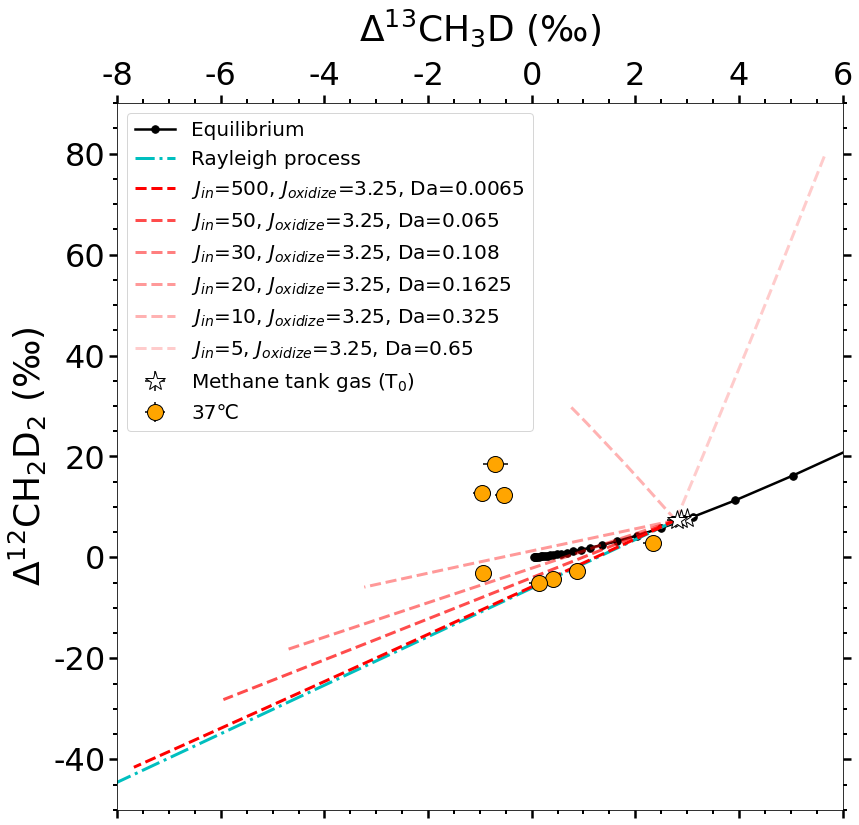

In [6]:
# Read the data from Ed's model

# Modeled data
D12CH2D2_model_500=read_data("Modeling/500_D12CH2D2_output.txt")
D13CH3D_model_500=read_data("Modeling/500_D13CH3D_output.txt")
d13C_model_500=read_data("Modeling/500_d13C_CH4_output.txt")
dD_model_500=read_data("Modeling/500_dD_CH4_output.txt")

D12CH2D2_model_200=read_data("Modeling/200_D12CH2D2_output.txt")
D13CH3D_model_200=read_data("Modeling/200_D13CH3D_output.txt")
d13C_model_200=read_data("Modeling/200_d13C_CH4_output.txt")
dD_model_200=read_data("Modeling/200_dD_CH4_output.txt")

D12CH2D2_model_50=read_data("Modeling/50_D12CH2D2_output.txt")
D13CH3D_model_50=read_data("Modeling/50_D13CH3D_output.txt")
d13C_model_50=read_data("Modeling/50_d13C_CH4_output.txt")
dD_model_50=read_data("Modeling/50_dD_CH4_output.txt")

D12CH2D2_model_30=read_data("Modeling/30_D12CH2D2_output.txt")
D13CH3D_model_30=read_data("Modeling/30_D13CH3D_output.txt")
d13C_model_30=read_data("Modeling/30_d13C_CH4_output.txt")
dD_model_30=read_data("Modeling/30_dD_CH4_output.txt")

D12CH2D2_model_20=read_data("Modeling/20_D12CH2D2_output.txt")
D13CH3D_model_20=read_data("Modeling/20_D13CH3D_output.txt")
d13C_model_20=read_data("Modeling/20_d13C_CH4_output.txt")
dD_model_20=read_data("Modeling/20_dD_CH4_output.txt")

D12CH2D2_model_10=read_data("Modeling/10_D12CH2D2_output.txt")
D13CH3D_model_10=read_data("Modeling/10_D13CH3D_output.txt")
d13C_model_10=read_data("Modeling/10_d13C_CH4_output.txt")
dD_model_10=read_data("Modeling/10_dD_CH4_output.txt")

D12CH2D2_model_5=read_data("Modeling/5_D12CH2D2_output.txt")
D13CH3D_model_5=read_data("Modeling/5_D13CH3D_output.txt")
d13C_model_5=read_data("Modeling/5_d13C_CH4_output.txt")
dD_model_5=read_data("Modeling/5_dD_CH4_output.txt")

fig_model,ax_model=plt.subplots(figsize = (13,13))
ax_model.errorbar(zero['D13CH3D'],zero['D12CH2D2'], xerr=zero['D13CH3D 1 se'],yerr=zero['D12CH2D2 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black', ecolor='black', zorder=10)
ax_model.plot(equib['D13CH3D'], equib['D12CH2D2'], '.-k', label = 'Equilibrium', linewidth = 2.5, markersize = 15)
ax_model.errorbar(Temp_37['D13CH3D'],Temp_37['D12CH2D2'],
                  xerr=Temp_37['D13CH3D 1 se'], yerr=Temp_37['D12CH2D2 1 se'],
                  markersize=16,label='37\u2103', fmt='o', markerfacecolor='orange', markeredgecolor='black', ecolor='black')
# Pure Rayleigh
a13=0.9671
aD=0.6967
aCD=0.6716
aDD=0.4309
f_plot=np.linspace(0.2,1.00,20)
D13CH3D_R=zeros(20)
D12CH2D2_R=zeros(20)
for i in range(0,20):
    D13CH3D_R[i]=2.809+(aCD-a13-aD+1)* math.log(f_plot[i])*1000
    D12CH2D2_R[i]=7.417+(aDD-2*aD+1)* math.log(f_plot[i])*1000
ax_model.plot(D13CH3D_R,D12CH2D2_R, '-.c', linewidth = 3.0, label='Rayleigh process')
ax_model.plot(D13CH3D_model_500, D12CH2D2_model_500, '--r', alpha=1.0,
              label = '$J_{in}$=500, $J_{oxidize}$=3.25, Da=0.0065', linewidth = 3.0)
ax_model.plot(D13CH3D_model_50, D12CH2D2_model_50, '--r', alpha=0.7,
              label = '$J_{in}$=50, $J_{oxidize}$=3.25, Da=0.065', linewidth = 3.0)
ax_model.plot(D13CH3D_model_30, D12CH2D2_model_30, '--r', alpha=0.5,
              label = '$J_{in}$=30, $J_{oxidize}$=3.25, Da=0.108', linewidth = 3.0)
ax_model.plot(D13CH3D_model_20, D12CH2D2_model_20, '--r', alpha=0.4,
              label = '$J_{in}$=20, $J_{oxidize}$=3.25, Da=0.1625', linewidth = 3.0)
ax_model.plot(D13CH3D_model_10, D12CH2D2_model_10, '--r', alpha=0.3,
              label = '$J_{in}$=10, $J_{oxidize}$=3.25, Da=0.325', linewidth = 3.0)
ax_model.plot(D13CH3D_model_5, D12CH2D2_model_5, '--r', alpha=0.2,
              label = '$J_{in}$=5, $J_{oxidize}$=3.25, Da=0.65', linewidth = 3.0)

ax_model.legend(loc='upper left',fontsize=20)
ax_model.set_xlabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict = font_labels, labelpad=20)
ax_model.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict = font_labels)
ax_model.xaxis.set_label_position("top")
plt.xlim([-8,6])
plt.ylim([-50,90])
ax_model.set_yticklabels(ax_model.get_yticks(),fontdict=font_ticks)
ax_model.set_xticklabels(ax_model.get_xticks(),fontdict=font_ticks)
ax_model.yaxis.set_minor_locator(MultipleLocator(5))
ax_model.xaxis.set_minor_locator(MultipleLocator(0.5))
ax_model.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_model.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_model.tick_params(which='major',direction='out', length=8, width=2.5, 
                     top=True, right= True, labelbottom=False, labeltop=True)
ax_model.tick_params(which='minor',direction='out', length=4, width=2.0, top=True, right= True)
fig_model.savefig('model_clump.pdf',bbox_inches = 'tight')
plt.show()

<ipython-input-7-5f4557e54e26>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_modelo.set_yticklabels(ax_modelo.get_yticks(),fontdict=font_ticks)
<ipython-input-7-5f4557e54e26>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_modelo.set_xticklabels(ax_modelo.get_xticks(),fontdict=font_ticks)


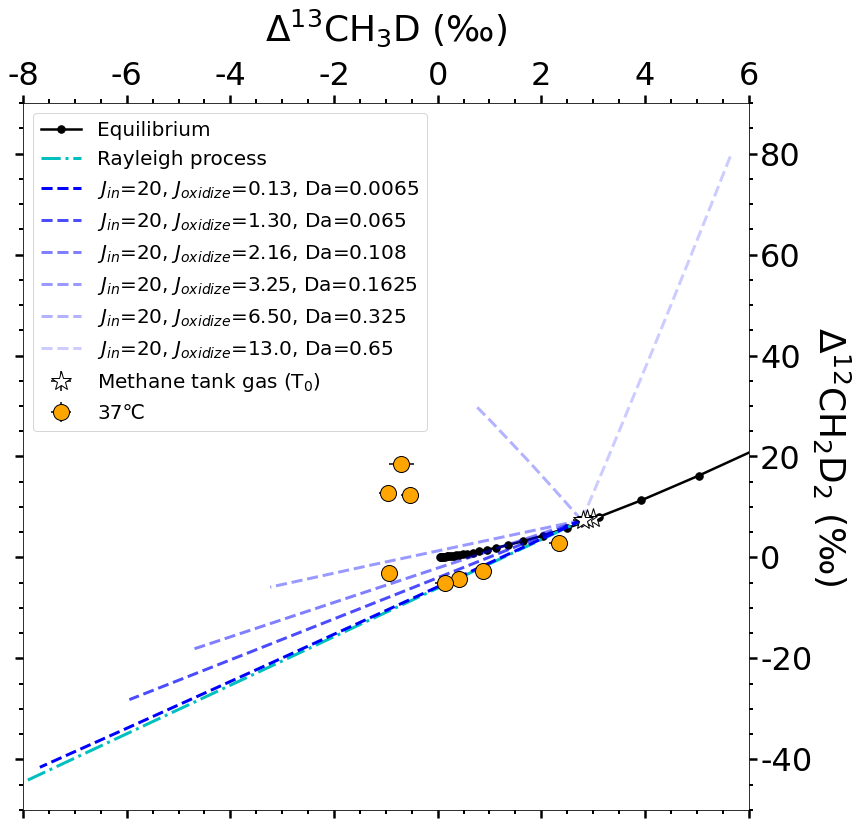

In [7]:
# Modeled data
D12CH2D2_model_o004=read_data("Modeling/o004_D12CH2D2_output.txt")
D13CH3D_model_o004=read_data("Modeling/o004_D13CH3D_output.txt")
d13C_model_o004=read_data("Modeling/o004_d13C_CH4_output.txt")
dD_model_o004=read_data("Modeling/o004_dD_CH4_output.txt")

D12CH2D2_model_o01=read_data("Modeling/o01_D12CH2D2_output.txt")
D13CH3D_model_o01=read_data("Modeling/o01_D13CH3D_output.txt")
d13C_model_o01=read_data("Modeling/o01_d13C_CH4_output.txt")
dD_model_o01=read_data("Modeling/o01_dD_CH4_output.txt")

D12CH2D2_model_o04=read_data("Modeling/o04_D12CH2D2_output.txt")
D13CH3D_model_o04=read_data("Modeling/o04_D13CH3D_output.txt")
d13C_model_o04=read_data("Modeling/o04_d13C_CH4_output.txt")
dD_model_o04=read_data("Modeling/o04_dD_CH4_output.txt")

D12CH2D2_model_o06=read_data("Modeling/o06_D12CH2D2_output.txt")
D13CH3D_model_o06=read_data("Modeling/o06_D13CH3D_output.txt")
d13C_model_o06=read_data("Modeling/o06_d13C_CH4_output.txt")
dD_model_o06=read_data("Modeling/o06_dD_CH4_output.txt")

D12CH2D2_model_o1=read_data("Modeling/o1_D12CH2D2_output.txt")
D13CH3D_model_o1=read_data("Modeling/o1_D13CH3D_output.txt")
d13C_model_o1=read_data("Modeling/o1_d13C_CH4_output.txt")
dD_model_o1=read_data("Modeling/o1_dD_CH4_output.txt")

D12CH2D2_model_o2=read_data("Modeling/o2_D12CH2D2_output.txt")
D13CH3D_model_o2=read_data("Modeling/o2_D13CH3D_output.txt")
d13C_model_o2=read_data("Modeling/o2_d13C_CH4_output.txt")
dD_model_o2=read_data("Modeling/o2_dD_CH4_output.txt")

D12CH2D2_model_o4=read_data("Modeling/o4_D12CH2D2_output.txt")
D13CH3D_model_o4=read_data("Modeling/o4_D13CH3D_output.txt")
d13C_model_o4=read_data("Modeling/o4_d13C_CH4_output.txt")
dD_model_o4=read_data("Modeling/o4_dD_CH4_output.txt")

fig_modelo,ax_modelo=plt.subplots(figsize = (13,13))
ax_modelo.errorbar(zero['D13CH3D'],zero['D12CH2D2'], xerr=zero['D13CH3D 1 se'],yerr=zero['D12CH2D2 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black',ecolor='black',zorder=10)
ax_modelo.plot(equib['D13CH3D'], equib['D12CH2D2'], '.-k', label = 'Equilibrium', linewidth = 2.5, markersize = 15)
ax_modelo.errorbar(Temp_37['D13CH3D'],Temp_37['D12CH2D2'],
                  xerr=Temp_37['D13CH3D 1 se'], yerr=Temp_37['D12CH2D2 1 se'],
                  markersize=16,label='37\u2103', fmt='o', markerfacecolor='orange', markeredgecolor='black', 
                   ecolor='black')
ax_modelo.plot(D13CH3D_R,D12CH2D2_R, '-.c', linewidth = 3.0, label='Rayleigh process')
ax_modelo.plot(D13CH3D_model_o004, D12CH2D2_model_o004, '--b', alpha=1.0,
              label = '$J_{in}$=20, $J_{oxidize}$=0.13, Da=0.0065', linewidth = 3.0)
ax_modelo.plot(D13CH3D_model_o04, D12CH2D2_model_o04, '--b', alpha=0.7,
              label = '$J_{in}$=20, $J_{oxidize}$=1.30, Da=0.065', linewidth = 3.0)
ax_modelo.plot(D13CH3D_model_o06, D12CH2D2_model_o06, '--b', alpha=0.5,
              label = '$J_{in}$=20, $J_{oxidize}$=2.16, Da=0.108', linewidth = 3.0)
ax_modelo.plot(D13CH3D_model_o1, D12CH2D2_model_o1, '--b', alpha=0.4,
              label = '$J_{in}$=20, $J_{oxidize}$=3.25, Da=0.1625', linewidth = 3.0)
ax_modelo.plot(D13CH3D_model_o2, D12CH2D2_model_o2, '--b', alpha=0.3,
              label = '$J_{in}$=20, $J_{oxidize}$=6.50, Da=0.325', linewidth = 3.0)
ax_modelo.plot(D13CH3D_model_o4, D12CH2D2_model_o4, '--b', alpha=0.2,
              label = '$J_{in}$=20, $J_{oxidize}$=13.0, Da=0.65', linewidth = 3.0)

ax_modelo.legend(loc='upper left',fontsize=20)
ax_modelo.set_xlabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict = font_labels, labelpad=20)
ax_modelo.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict = font_labels, rotation=270, labelpad=40)
ax_modelo.xaxis.set_label_position('top')
ax_modelo.yaxis.set_label_position('right')
plt.xlim([-8,6])
plt.ylim([-50,90])
ax_modelo.set_yticklabels(ax_modelo.get_yticks(),fontdict=font_ticks)
ax_modelo.set_xticklabels(ax_modelo.get_xticks(),fontdict=font_ticks)
ax_modelo.yaxis.set_minor_locator(MultipleLocator(5))
ax_modelo.xaxis.set_minor_locator(MultipleLocator(0.5))
ax_modelo.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_modelo.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_modelo.tick_params(which='major',direction='out', length=8, width=2.5, 
                      top=True, right=True, labelleft=False, labelright=True, labelbottom=False, labeltop=True)
ax_modelo.tick_params(which='minor',direction='out', length=4, width=2.0,
                     top=True, right=True)
fig_modelo.savefig('modelo_clump.pdf',bbox_inches = 'tight')
plt.show()

<ipython-input-8-c0646fa3bbe0>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_modelo_bulk.set_yticklabels(ax_modelo_bulk.get_yticks(),fontdict=font_ticks)
<ipython-input-8-c0646fa3bbe0>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_modelo_bulk.set_xticklabels(ax_modelo_bulk.get_xticks(),fontdict=font_ticks)


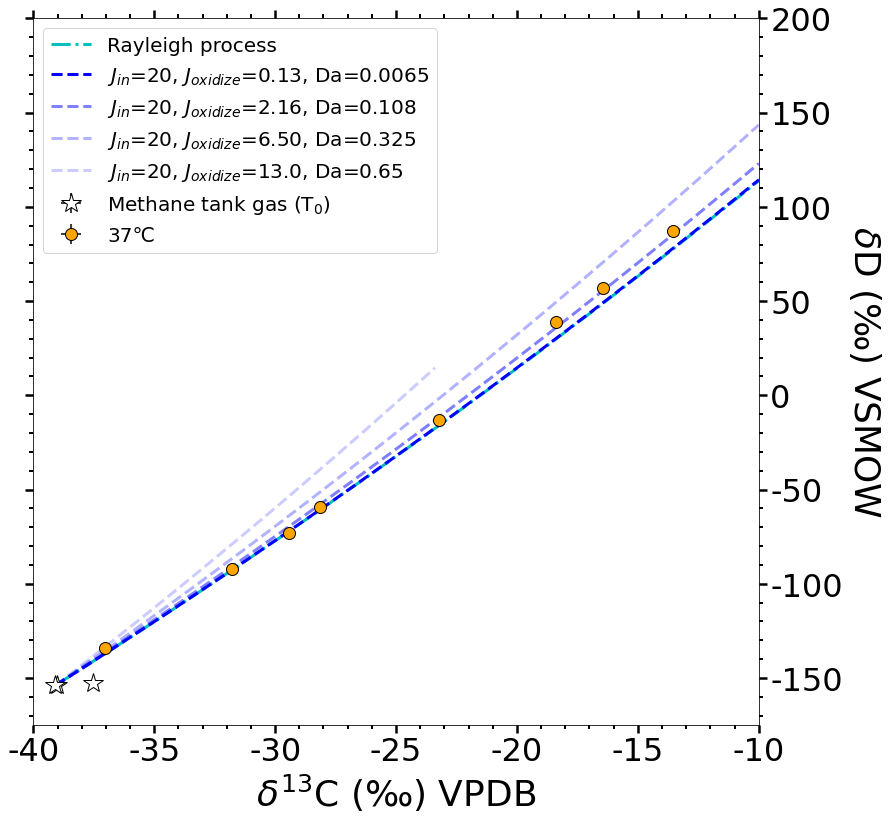

In [8]:
# Plot d13C and dD, oxidize rate sensitivity
# Pure Rayleigh
d13C_R=zeros(20)
dD_R=zeros(20)
for i in range(0,len(f_plot)):
    d13C_R[i]=(-39.095298+1000)*f_plot[i]**(a13-1)-1000
    dD_R[i]=(-153.968189+1000)*f_plot[i]**(aD-1)-1000
fig_modelo_bulk,ax_modelo_bulk=plt.subplots(figsize = (13,13))
ax_modelo_bulk.errorbar(zero['d13C PDB'],zero['dD SMOW'], xerr=zero['d13C 1 se'],yerr=zero['dD 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black',ecolor='black',zorder=10)
ax_modelo_bulk.errorbar(Temp_37['d13C PDB'],Temp_37['dD SMOW'],
                  xerr=Temp_37['d13C 1 se'], yerr=Temp_37['dD 1 se'],
                  markersize=12,label='37\u2103', fmt='o', markerfacecolor='orange', markeredgecolor='black',
                       ecolor='black')
ax_modelo_bulk.plot(d13C_R, dD_R, '-.c', linewidth = 3.0, label='Rayleigh process')
ax_modelo_bulk.plot(d13C_model_o004, dD_model_o004, '--b', label = '$J_{in}$=20, $J_{oxidize}$=0.13, Da=0.0065', linewidth= 3.0, alpha=1.0)
#ax_modelo_bulk.plot(d13C_model_o04, dD_model_o04, '--b', label = '$J_{in}$=20, $J_{oxidize}$=1.30', linewidth= 3.0, alpha=0.7)
ax_modelo_bulk.plot(d13C_model_o06, dD_model_o06, '--b', label = '$J_{in}$=20, $J_{oxidize}$=2.16, Da=0.108', linewidth= 3.0, alpha=0.5)
#ax_modelo_bulk.plot(d13C_model_o1, dD_model_o1, '--b', label = '$J_{in}$=20, $J_{oxidize}$=3.25', linewidth= 3.0, alpha=0.4)
ax_modelo_bulk.plot(d13C_model_o2, dD_model_o2, '--b', label = '$J_{in}$=20, $J_{oxidize}$=6.50, Da=0.325', linewidth= 3.0, alpha=0.3)
ax_modelo_bulk.plot(d13C_model_o4, dD_model_o4, '--b', label = '$J_{in}$=20, $J_{oxidize}$=13.0, Da=0.65', linewidth= 3.0, alpha=0.2)
ax_modelo_bulk.set_ylabel('$\delta$D (\u2030) VSMOW', fontdict=font_labels, rotation=270, labelpad=40)
ax_modelo_bulk.set_xlabel('$\delta^{13}$C (\u2030) VPDB', fontdict=font_labels)
ax_modelo_bulk.yaxis.set_label_position('right')
plt.xlim([-40,-10])
plt.ylim([-175,200])
ax_modelo_bulk.set_yticklabels(ax_modelo_bulk.get_yticks(),fontdict=font_ticks)
ax_modelo_bulk.set_xticklabels(ax_modelo_bulk.get_xticks(),fontdict=font_ticks)
ax_modelo_bulk.yaxis.set_minor_locator(MultipleLocator(10))
ax_modelo_bulk.xaxis.set_minor_locator(MultipleLocator(1))
ax_modelo_bulk.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_modelo_bulk.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_modelo_bulk.tick_params(which='major',direction='out', length=8, width=2.5,
                          top=True, right=True, labelleft=False, labelright=True)
ax_modelo_bulk.tick_params(which='minor',direction='out', length=4, width=2.0,
                          top=True, right=True)
ax_modelo_bulk.legend(fontsize=20)
plt.show()
fig_modelo_bulk.savefig('modelo_bulk.pdf',bbox_inches = 'tight')


<ipython-input-9-0e6ff4c50283>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_model_bulk.set_yticklabels(ax_model_bulk.get_yticks(),fontdict=font_ticks)
<ipython-input-9-0e6ff4c50283>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_model_bulk.set_xticklabels(ax_model_bulk.get_xticks(),fontdict=font_ticks)


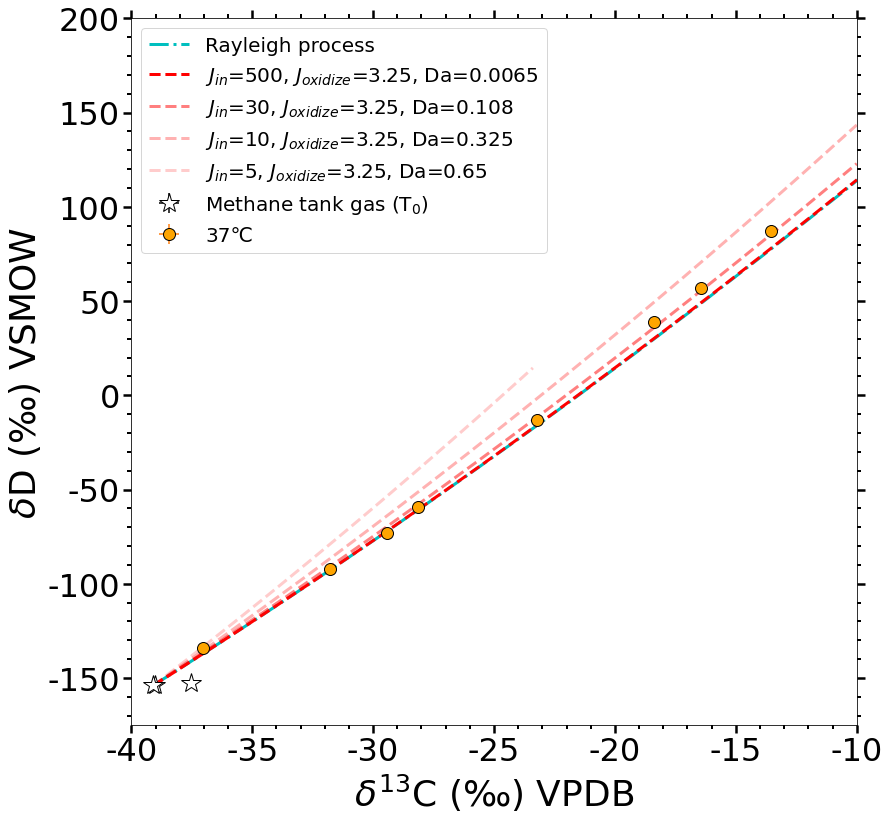

In [9]:
# Plot d13C and dD
fig_model_bulk,ax_model_bulk=plt.subplots(figsize = (13,13))
ax_model_bulk.errorbar(zero['d13C PDB'],zero['dD SMOW'], xerr=zero['d13C 1 se'],yerr=zero['dD 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black',ecolor='black',zorder=10)
ax_model_bulk.errorbar(Temp_37['d13C PDB'],Temp_37['dD SMOW'],
                  xerr=Temp_37['d13C 1 se'], yerr=Temp_37['dD 1 se'],
                  markersize=12,label='37\u2103', fmt='o', markerfacecolor='orange', markeredgecolor='black')
ax_model_bulk.plot(d13C_R, dD_R, '-.c', linewidth = 3.0, label='Rayleigh process')
ax_model_bulk.plot(d13C_model_500, dD_model_500, '--r', label = '$J_{in}$=500, $J_{oxidize}$=3.25, Da=0.0065', linewidth= 3.0, alpha=1.0)
#ax_model_bulk.plot(d13C_model_50, dD_model_50, '--r', label = '$J_{in}$=50, $J_{oxidize}$=3.25', linewidth= 3.0, alpha=0.7)
ax_model_bulk.plot(d13C_model_30, dD_model_30, '--r', label = '$J_{in}$=30, $J_{oxidize}$=3.25, Da=0.108', linewidth= 3.0, alpha=0.5)
#ax_model_bulk.plot(d13C_model_20, dD_model_20, '--r', label = '$J_{in}$=20, $J_{oxidize}$=3.25', linewidth= 3.0, alpha=0.4)
ax_model_bulk.plot(d13C_model_10, dD_model_10, '--r', label = '$J_{in}$=10, $J_{oxidize}$=3.25, Da=0.325', linewidth= 3.0, alpha=0.3)
ax_model_bulk.plot(d13C_model_5, dD_model_5, '--r', label = '$J_{in}$=5, $J_{oxidize}$=3.25, Da=0.65', linewidth= 3.0, alpha=0.2)
ax_model_bulk.set_ylabel('$\delta$D (\u2030) VSMOW', fontdict=font_labels)
ax_model_bulk.set_xlabel('$\delta^{13}$C (\u2030) VPDB', fontdict=font_labels)
plt.xlim([-40,-10])
plt.ylim([-175,200])
ax_model_bulk.set_yticklabels(ax_model_bulk.get_yticks(),fontdict=font_ticks)
ax_model_bulk.set_xticklabels(ax_model_bulk.get_xticks(),fontdict=font_ticks)
ax_model_bulk.yaxis.set_minor_locator(MultipleLocator(10))
ax_model_bulk.xaxis.set_minor_locator(MultipleLocator(1))
ax_model_bulk.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_model_bulk.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_model_bulk.tick_params(which='major',direction='out', length=8, width=2.5, top=True, right=True)
ax_model_bulk.tick_params(which='minor',direction='out', length=4, width=2.0, top=True, right=True)
ax_model_bulk.legend(fontsize=20)

plt.show()
fig_model_bulk.savefig('model_bulk.pdf',bbox_inches = 'tight')

<ipython-input-10-1869940aac9e>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_vmodel.set_yticklabels(ax_vmodel.get_yticks(),fontdict=font_ticks)
<ipython-input-10-1869940aac9e>:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_vmodel.set_xticklabels(ax_vmodel.get_xticks(),fontdict=font_ticks)


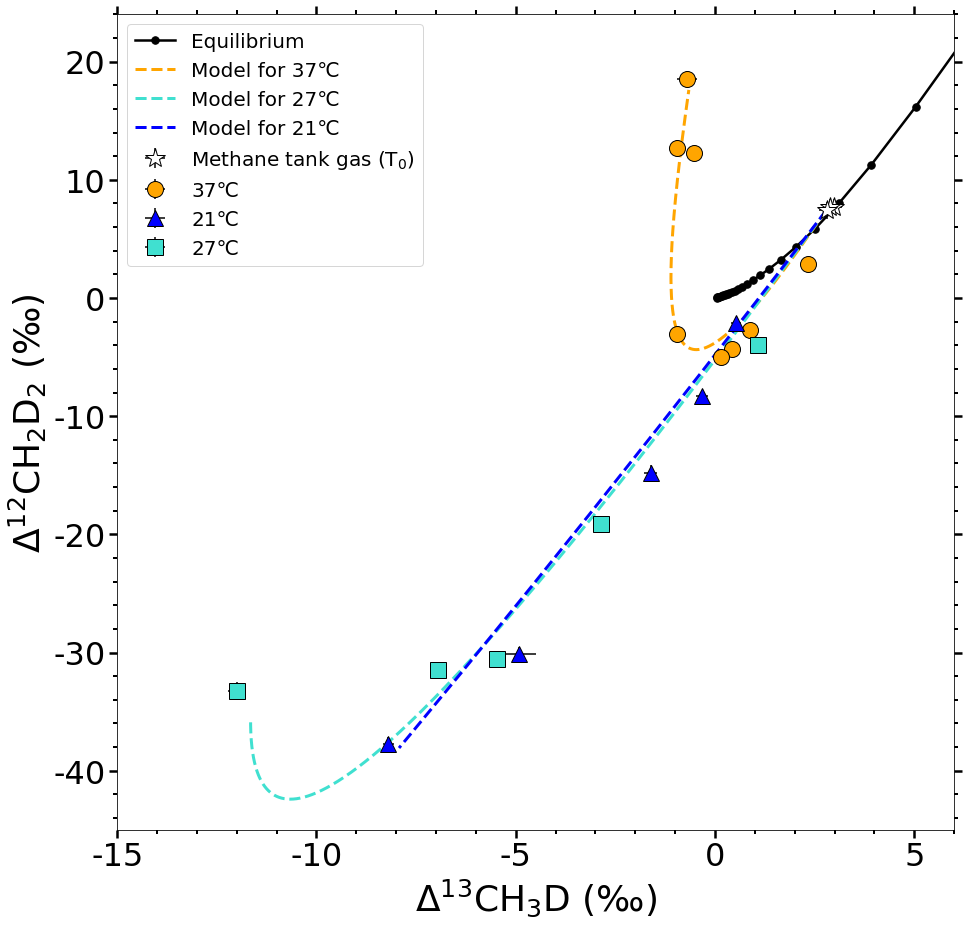

In [10]:
D12CH2D2_model_v37=read_data("Modeling/v37_D12CH2D2_output.txt")
D13CH3D_model_v37=read_data("Modeling/v37_D13CH3D_output.txt")
d13C_model_v37=read_data("Modeling/v37_d13C_CH4_output.txt")
dD_model_v37=read_data("Modeling/v37_dD_CH4_output.txt")

D12CH2D2_model_v27=read_data("Modeling/v27_D12CH2D2_output.txt")
D13CH3D_model_v27=read_data("Modeling/v27_D13CH3D_output.txt")
d13C_model_v27=read_data("Modeling/v27_d13C_CH4_output.txt")
dD_model_v27=read_data("Modeling/v27_dD_CH4_output.txt")

D12CH2D2_model_v21=read_data("Modeling/v21_D12CH2D2_output.txt")
D13CH3D_model_v21=read_data("Modeling/v21_D13CH3D_output.txt")
d13C_model_v21=read_data("Modeling/v21_d13C_CH4_output.txt")
dD_model_v21=read_data("Modeling/v21_dD_CH4_output.txt")

fig_vmodel,ax_vmodel=plt.subplots(figsize = (15,15))
ax_vmodel.errorbar(zero['D13CH3D'],zero['D12CH2D2'], xerr=zero['D13CH3D 1 se'],yerr=zero['D12CH2D2 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black', ecolor='black',zorder=10)
ax_vmodel.plot(equib['D13CH3D'], equib['D12CH2D2'], '.-k', label = 'Equilibrium', linewidth = 2.5, markersize = 15)
ax_vmodel.errorbar(Temp_37['D13CH3D'],Temp_37['D12CH2D2'],
                  xerr=Temp_37['D13CH3D 1 se'], yerr=Temp_37['D12CH2D2 1 se'],
                  markersize=16,label='37\u2103', fmt='o', markerfacecolor='orange', markeredgecolor='black',
                  ecolor='black')
ax_vmodel.errorbar(Temp_21['D13CH3D'],Temp_21['D12CH2D2'],
                  xerr=Temp_21['D13CH3D 1 se'], yerr=Temp_21['D12CH2D2 1 se'],
                  markersize=16,label='21\u2103', fmt='^', markerfacecolor='blue', markeredgecolor='black',
                  ecolor='black')
ax_vmodel.errorbar(Temp_27['D13CH3D'],Temp_27['D12CH2D2'],
                  xerr=Temp_27['D13CH3D 1 se'], yerr=Temp_27['D12CH2D2 1 se'],
                  markersize=16,label='27\u2103', fmt='s', markerfacecolor='turquoise', markeredgecolor='black',
                  ecolor='black')

ax_vmodel.plot(D13CH3D_model_v37, D12CH2D2_model_v37, '--', color="orange", alpha=1.0,
              label = 'Model for 37\u2103', linewidth = 3.0)
ax_vmodel.plot(D13CH3D_model_v27, D12CH2D2_model_v27, '--', color="turquoise", alpha=1.0,
              label = 'Model for 27\u2103', linewidth = 3.0)
ax_vmodel.plot(D13CH3D_model_v21, D12CH2D2_model_v21, '--', color="blue", alpha=1.0,
              label = 'Model for 21\u2103', linewidth = 3.0)
ax_vmodel.legend(loc='upper left',fontsize=20)
ax_vmodel.set_xlabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict = font_labels)
ax_vmodel.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict = font_labels)
plt.xlim([-15,6])
plt.ylim([-45,24])
ax_vmodel.yaxis.set_major_locator(MultipleLocator(10))
ax_vmodel.yaxis.set_minor_locator(MultipleLocator(2))
ax_vmodel.xaxis.set_major_locator(MultipleLocator(5))
ax_vmodel.xaxis.set_minor_locator(MultipleLocator(1))
ax_vmodel.set_yticklabels(ax_vmodel.get_yticks(),fontdict=font_ticks)
ax_vmodel.set_xticklabels(ax_vmodel.get_xticks(),fontdict=font_ticks)
ax_vmodel.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_vmodel.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_vmodel.tick_params(which='major',direction='out', length=8, width=2.5,
                     top=True,right=True)
ax_vmodel.tick_params(which='minor',direction='out', length=4, width=2.0,
                     top=True,right=True)
fig_vmodel.savefig('model_clump_v.pdf',bbox_inches = 'tight')
plt.show()

<ipython-input-11-4045a1cda99e>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_model_bulk_v.set_yticklabels(ax_model_bulk_v.get_yticks(),fontdict=font_ticks)
<ipython-input-11-4045a1cda99e>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_model_bulk_v.set_xticklabels(ax_model_bulk_v.get_xticks(),fontdict=font_ticks)


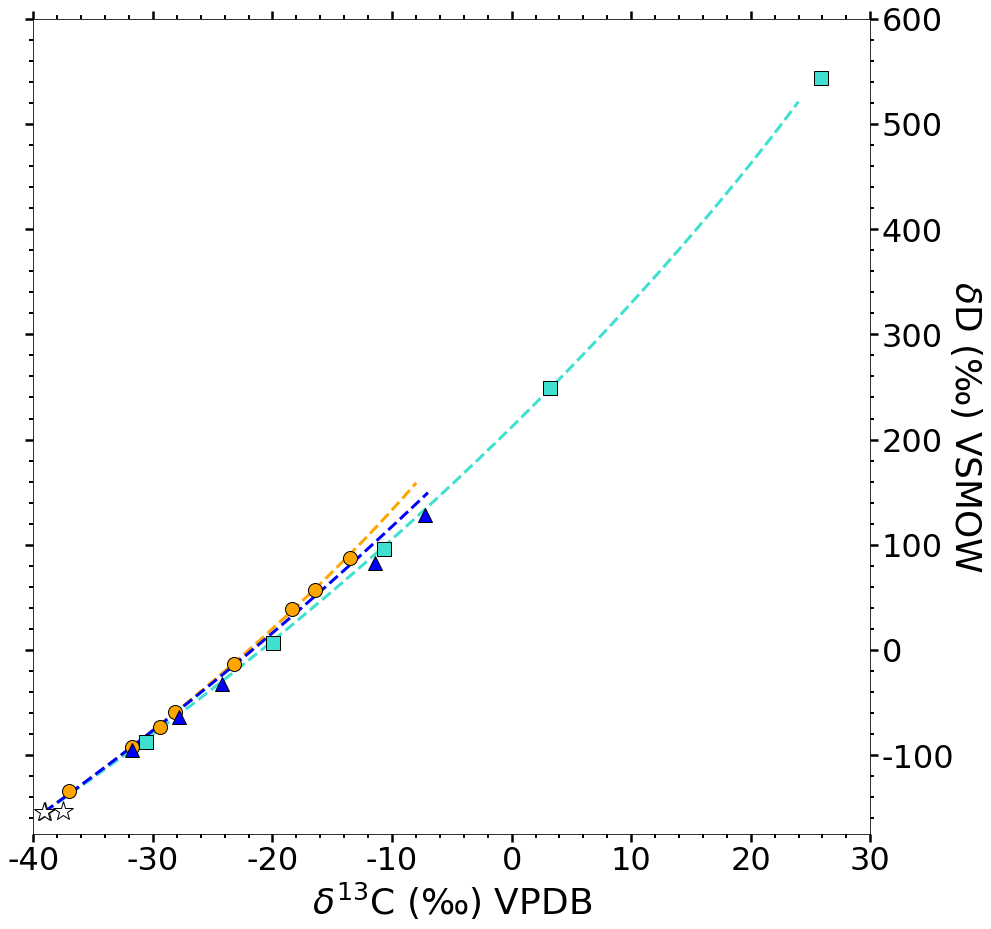

In [11]:
fig_model_bulk_v,ax_model_bulk_v=plt.subplots(figsize = (15,15))
ax_model_bulk_v.errorbar(zero['d13C PDB'],zero['dD SMOW'], xerr=zero['d13C 1 se'],yerr=zero['dD 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black',zorder=10)
ax_model_bulk_v.errorbar(Temp_37['d13C PDB'],Temp_37['dD SMOW'],
                  xerr=Temp_37['d13C 1 se'], yerr=Temp_37['dD 1 se'],
                  markersize=14,label='37\u2103, low Cu', fmt='o', markerfacecolor='orange', markeredgecolor='black',
                        ecolor='black')
ax_model_bulk_v.errorbar(Temp_27['d13C PDB'],Temp_27['dD SMOW'],
                  xerr=Temp_27['d13C 1 se'], yerr=Temp_27['dD 1 se'],
                  markersize=14,label='27\u2103, low Cu', fmt='s', markerfacecolor='turquoise', markeredgecolor='black',
                        ecolor='black')
ax_model_bulk_v.errorbar(Temp_21['d13C PDB'],Temp_21['dD SMOW'],
                  xerr=Temp_21['d13C 1 se'], yerr=Temp_21['dD 1 se'],
                  markersize=14,label='21\u2103, low Cu', fmt='^', markerfacecolor='blue', markeredgecolor='black',
                        ecolor='black')
ax_model_bulk_v.plot(d13C_model_v37, dD_model_v37, '--', color='orange', 
                     label = 'Model for 37\u2103, low Cu', linewidth= 3.0, alpha=1.0)
ax_model_bulk_v.plot(d13C_model_v27, dD_model_v27, '--', color='turquoise', 
                     label = 'Model for 27\u2103, low Cu', linewidth= 3.0, alpha=1.0)
ax_model_bulk_v.plot(d13C_model_v21, dD_model_v21, '--', color='blue', 
                     label = 'Model for 21\u2103, low Cu', linewidth= 3.0, alpha=1.0)
ax_model_bulk_v.set_ylabel('$\delta$D (\u2030) VSMOW', fontdict=font_labels, rotation=270, labelpad=30)
ax_model_bulk_v.set_xlabel('$\delta^{13}$C (\u2030) VPDB', fontdict=font_labels)
ax_model_bulk_v.yaxis.set_label_position('right')
plt.xlim([-40,30])
plt.ylim([-175,600])
ax_model_bulk_v.set_yticklabels(ax_model_bulk_v.get_yticks(),fontdict=font_ticks)
ax_model_bulk_v.set_xticklabels(ax_model_bulk_v.get_xticks(),fontdict=font_ticks)
ax_model_bulk_v.yaxis.set_minor_locator(MultipleLocator(20))
ax_model_bulk_v.xaxis.set_minor_locator(MultipleLocator(2))
ax_model_bulk_v.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_model_bulk_v.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_model_bulk_v.tick_params(which='major',direction='out', length=8, width=2.5,
                           top=True,right=True, labelleft=False, labelright=True)
ax_model_bulk_v.tick_params(which='minor',direction='out', length=4, width=2.0,
                           top=True,right=True)
# ax_model_bulk_v.legend(fontsize=20)
plt.show()
fig_model_bulk_v.savefig('model_bulk_v.pdf',bbox_inches = 'tight')

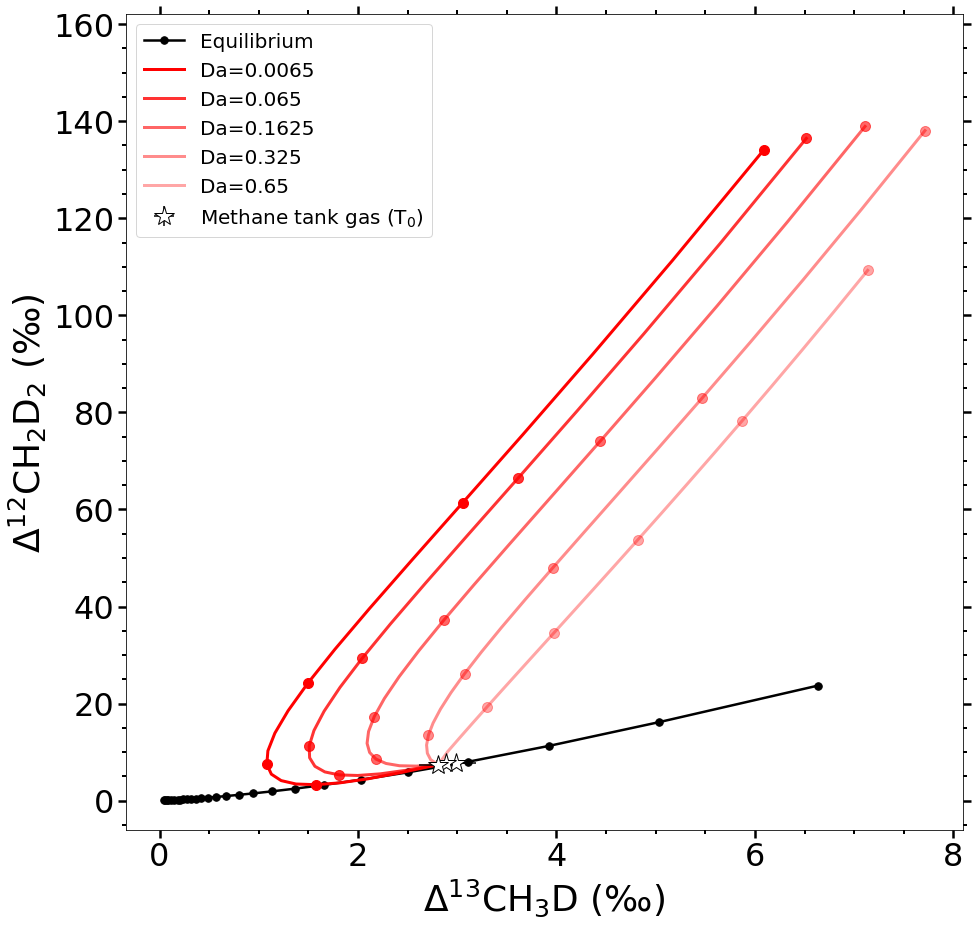

In [12]:
# Read the data
os=pd.read_excel("open_system.xlsx")
fig_os1,ax_os1=plt.subplots(figsize = (15,15))
ax_os1.plot(equib['D13CH3D'], equib['D12CH2D2'], '.-k', label = 'Equilibrium', linewidth = 2.5, markersize = 15)
ax_os1.errorbar(zero['D13CH3D'],zero['D12CH2D2'], xerr=zero['D13CH3D 1 se'],yerr=zero['D12CH2D2 1 se'],
                  markersize=20, label=r'Methane tank gas (T$_0$)', 
                 fmt='*', markerfacecolor='white',markeredgecolor='black',ecolor='black',zorder=10)


ax_os1.plot(os['0.0065_13CD'], os['0.0065_DD'], '-r', alpha=1.0, linewidth=3,
              label = 'Da=0.0065')
ax_os1.plot(os['0.065_13CD'], os['0.065_DD'], '-r', alpha=0.8, linewidth=3,
              label = 'Da=0.065')
ax_os1.plot(os['0.1625_13CD'], os['0.1625_DD'], '-r', alpha=0.6, linewidth=3,
              label = 'Da=0.1625')
ax_os1.plot(os['0.325_13CD'], os['0.325_DD'], '-r', alpha=0.45, linewidth=3,
              label = 'Da=0.325')
ax_os1.plot(os['0.65_13CD'], os['0.65_DD'], '-r', alpha=0.35, linewidth=3,
              label = 'Da=0.65')

mask=[4,8,12,16,20]
ax_os1.scatter(os['0.0065_13CD'].iloc[mask], os['0.0065_DD'].iloc[mask],s=100,color='red', alpha=1.0,zorder=10)
ax_os1.scatter(os['0.065_13CD'].iloc[mask], os['0.065_DD'].iloc[mask],s=100,color='red', alpha=0.8)
ax_os1.scatter(os['0.1625_13CD'].iloc[mask], os['0.1625_DD'].iloc[mask],s=100,color='red', alpha=0.6)
ax_os1.scatter(os['0.325_13CD'].iloc[mask], os['0.325_DD'].iloc[mask],s=100,color='red', alpha=0.45)
ax_os1.scatter(os['0.65_13CD'].iloc[mask], os['0.65_DD'].iloc[mask],s=100,color='red', alpha=0.35)

ax_os1.legend(loc='upper left',fontsize=20)
ax_os1.set_xlabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict = font_labels)
ax_os1.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict = font_labels)
# plt.xlim([-2,8])
plt.ylim([-6,162])
ax_os1.yaxis.set_minor_locator(MultipleLocator(5))
ax_os1.xaxis.set_minor_locator(MultipleLocator(0.5))
ax_os1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_os1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax_os1.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32, 
                   top=True, right=True)
ax_os1.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32,
                  top=True, right=True)
fig_os1.savefig('model_clump_os.pdf',bbox_inches = 'tight')
plt.show()

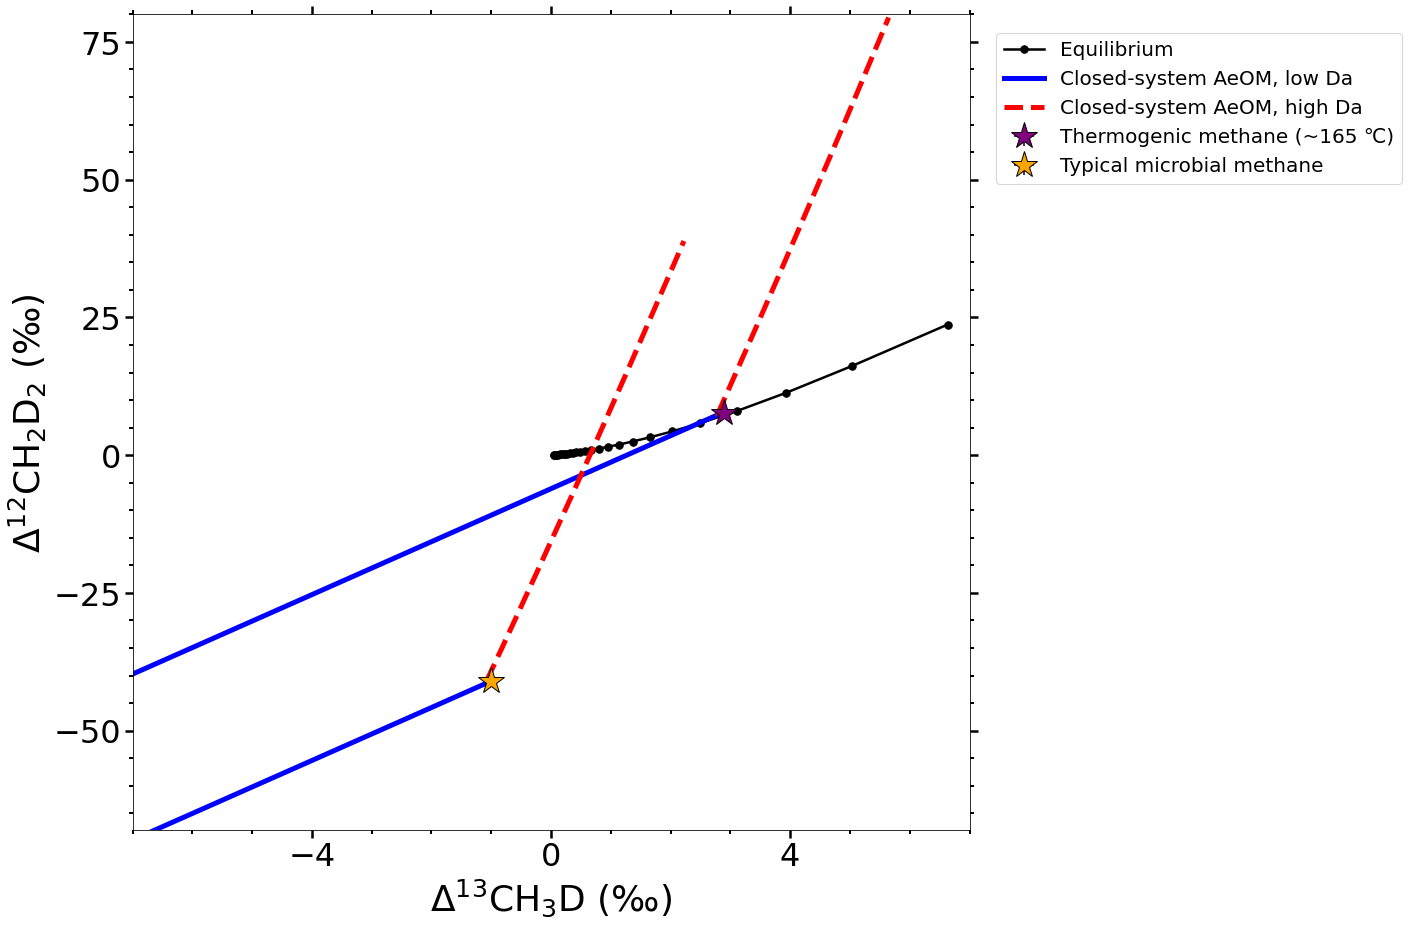

In [13]:
fig_sum,axs=plt.subplots(figsize = (15,15))
axs.plot(equib['D13CH3D'], equib['D12CH2D2'], '.-k', label = 'Equilibrium', linewidth = 2.5, markersize = 15)
axs.errorbar(zero['D13CH3D'].iloc[1],zero['D12CH2D2'].iloc[1], xerr=0,yerr=0,
                  markersize=28, label='Thermogenic methane (~165 \u2103)', 
                 fmt='*', markerfacecolor='purple',markeredgecolor='black',ecolor='black',zorder=10)
axs.plot(D13CH3D_R,D12CH2D2_R, '-b', linewidth = 5.0, label='Closed-system AeOM, low Da')
axs.plot(D13CH3D_model_o4, D12CH2D2_model_o4, '--r',
              label = 'Closed-system AeOM, high Da', linewidth = 5.0)

# Pure Rayleigh from microbial field
a13=0.9671
aD=0.6967
aCD=0.6716
aDD=0.4309
# f_plot=np.linspace(0.2,1.00,20)
D13CH3D_Rm=zeros(20)
D12CH2D2_Rm=zeros(20)
for i in range(0,20):
    D13CH3D_Rm[i]=-1+(aCD-a13-aD+1)* math.log(f_plot[i])*1000
    D12CH2D2_Rm[i]=-41+(aDD-2*aD+1)* math.log(f_plot[i])*1000

axs.errorbar(-1,-41, xerr=0,yerr=0,
                  markersize=28, label='Typical microbial methane', 
                 fmt='*', markerfacecolor='orange',markeredgecolor='black',ecolor='black',zorder=10)
axs.plot(D13CH3D_Rm,D12CH2D2_Rm, '-b', linewidth = 5.0)
D12CH2D2, D13CH3D, d13C, dD = read_model("summary")
axs.plot(D13CH3D,D12CH2D2, '--', color='red', linewidth = 5.0)

axs.legend(bbox_to_anchor=(1.02,0.99),fontsize=20)
axs.set_xlabel('$\Delta^{13}$CH$_3$D (\u2030)', fontdict = font_labels)
axs.set_ylabel('$\Delta^{12}$CH$_2$D$_2$ (\u2030)', fontdict = font_labels)
axs.set_xlim([-7,7])
axs.set_ylim([-68,80])
axs.yaxis.set_major_locator(MultipleLocator(25))
axs.yaxis.set_minor_locator(MultipleLocator(5))
axs.xaxis.set_minor_locator(MultipleLocator(1))
axs.xaxis.set_major_locator(MultipleLocator(4))
# axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
axs.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32, right=True, top=True)
axs.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32, right=True, top=True)
fig_sum.savefig('summary.pdf',bbox_inches = 'tight')
plt.show()

<ipython-input-14-53dac41e1d40>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  gcf1.set_yticklabels(gcf1.get_yticks(),fontdict=font_ticks)
<ipython-input-14-53dac41e1d40>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  gcf1.set_xticklabels(gcf1.get_xticks(),fontdict=font_ticks)


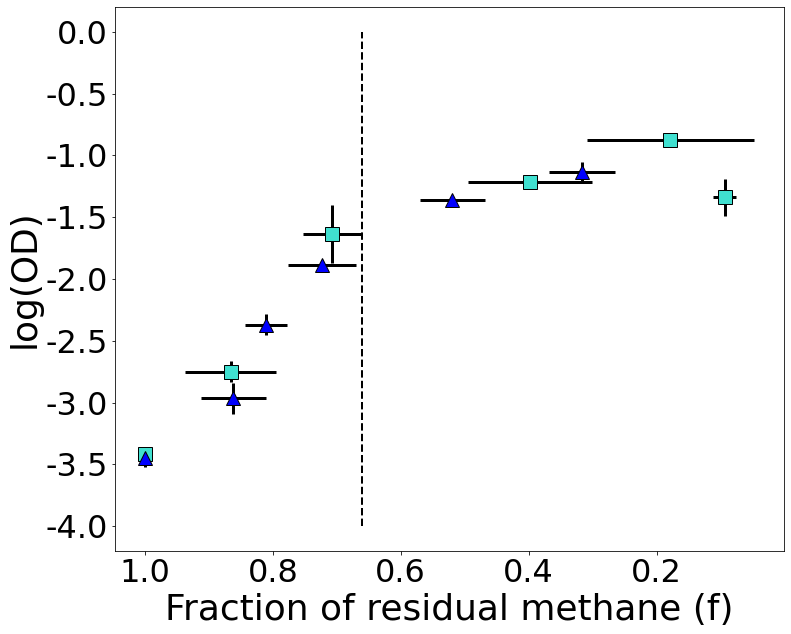

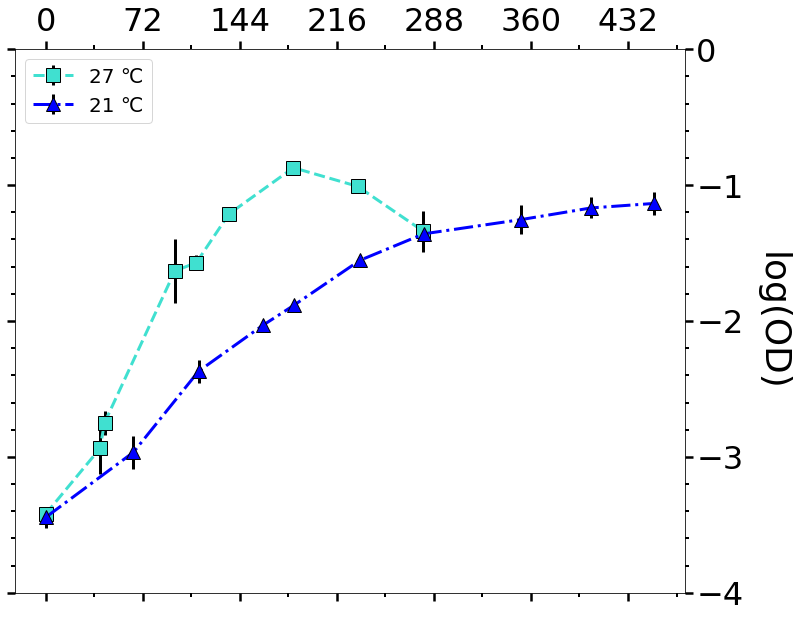

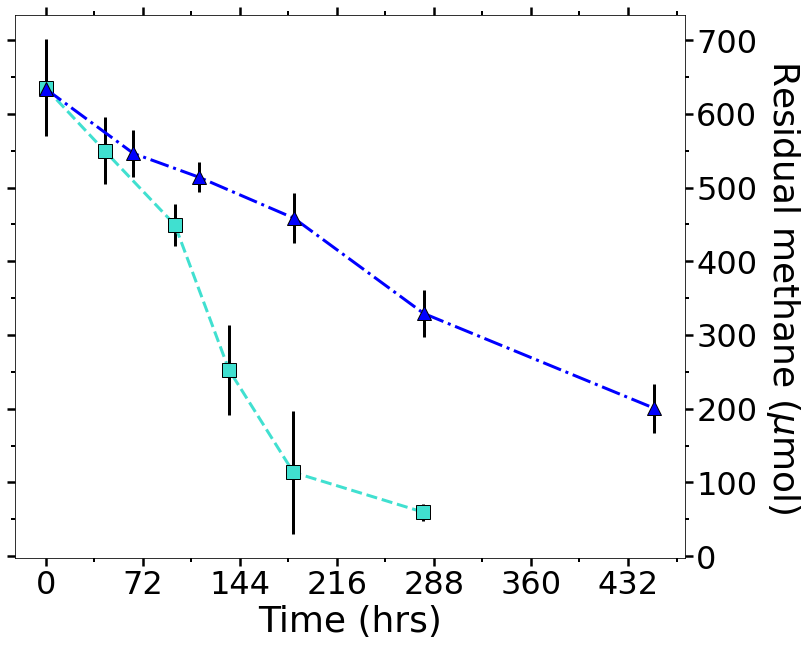

In [14]:
### Plot the growth curve against small f values
# 10/25/2021 37 C experiment
logscale=True
fig_gcf1, gcf1 = plt.subplots(figsize=(12,10))
fig_gct1, gct1 = plt.subplots(figsize=(12,10))
fig_met1, met1 = plt.subplots(figsize=(12,10))

od600_37_1= r"2021-10-25-37C/2021-10-25_37C_McapsForClumps_OD600s (Responses).xlsx"

# # 7/20/2022 37C
od600_37_2 = r"2022-7-20_Mcaps_13%CH4_37C_ForClumped/2022-07-20_37C_McapsForClumps_OD600s (Responses).xlsx"

# 6/9/2021 27 C
od600_27 = r"27C/2021-06-09_27C_McapsForClumps_OD600s (Responses).xlsx"
gcf(od600_27,gcf1,"27 \u2103","s",'turquoise')
gct(od600_27,gct1,"27 \u2103","--s",'turquoise')
met(od600_27,met1,"27 \u2103","--s",'turquoise')
# 1/17/2022 21C
od600_21 = r"21C/2022-01-17_Room Temperature_McapsForClumps_OD600s (Responses).xlsx"
gcf(od600_21,gcf1,"21 \u2103","^",'blue')
gct(od600_21,gct1,"21 \u2103","-.^",'blue')
met(od600_21,met1,"21 \u2103","-.^",'blue')
# # Cu free 37C
od600_cuf="2022-8-22_Mcaps_13%CH4_Cu_free_ForClumped/2022-08-22_Cu_free_McapsForClumps_OD600s (Responses).xlsx"

# # 50 uM Cu 37 C
od600_cuh="2022-8-24_Mcaps_13%CH4_50uM_Cu_ForClumped/2022-08-24_50uM_Cu_McapsForClumps_OD600s (Responses).xlsx"


gcf1.plot(4*[0.66],np.linspace(-4,0,4),"k--",linewidth=2.0,label="f=0.66")
gcf1.set_yticklabels(gcf1.get_yticks(),fontdict=font_ticks)
gcf1.set_xticklabels(gcf1.get_xticks(),fontdict=font_ticks)
gcf1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
gcf1.invert_xaxis()
#gcf1.legend(fontsize=15)

gct1.set_ylim([-4,0])
#gct1.set_xlim([-10,48])
gct1.set_ylabel('log(OD)',rotation=270,labelpad=45)
gct1.set_xlabel('')
gct1.yaxis.set_label_position('right')
gct1.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32,
                right=True, top=True, labelleft=False, labelright=True,
                labelbottom=False,labeltop=True)
gct1.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32,
                right=True, top=True)
gct1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
gct1.xaxis.set_minor_locator(ticker.MultipleLocator(36))
gct1.xaxis.set_major_locator(ticker.MultipleLocator(72))
gct1.yaxis.set_major_locator(ticker.MultipleLocator(1))
gct1.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
gct1.legend(fontsize=20, loc='upper left')

#met1.plot(np.linspace(0,500,10),10*[0.66],"k--",linewidth=2.0,label="f=0.66")
#met1.set_xlim([0,48])

met1.set_ylabel('Residual methane ($\mu$mol)',rotation=270,labelpad=45)
met1.yaxis.set_label_position('right')
met1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
met1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# met1.legend(fontsize=15)
met1.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32,
                right=True, top=True, labelleft=False, labelright=True)
met1.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32,
                right=True, top=True)
met1.yaxis.set_minor_locator(ticker.MultipleLocator(50))
met1.xaxis.set_major_locator(ticker.MultipleLocator(72))
met1.xaxis.set_minor_locator(ticker.MultipleLocator(36))


plt.show()
fig_gcf1.savefig("OD_f.pdf",bbox_inches='tight')
fig_gct1.savefig("OD_t.pdf", bbox_inches='tight')
fig_met1.savefig("CH4_t.pdf", bbox_inches='tight')

<ipython-input-15-eb7120164b5b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  gcf2.set_yticklabels(gcf1.get_yticks(),fontdict=font_ticks)
<ipython-input-15-eb7120164b5b>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  gcf2.set_xticklabels(gcf1.get_xticks(),fontdict=font_ticks)


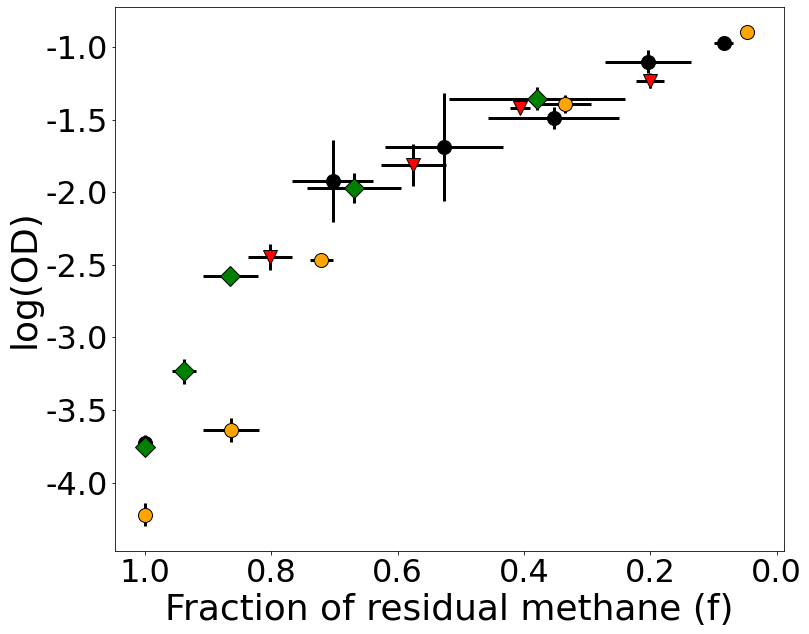

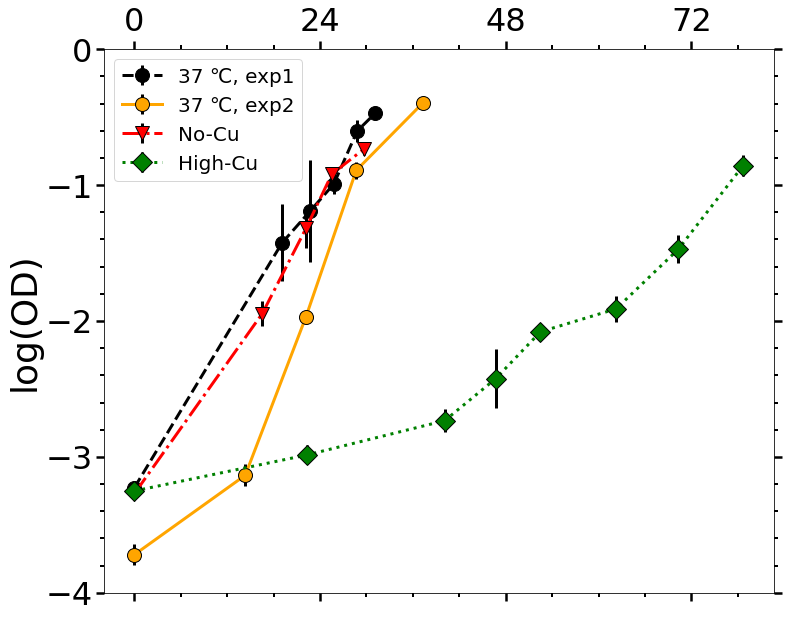

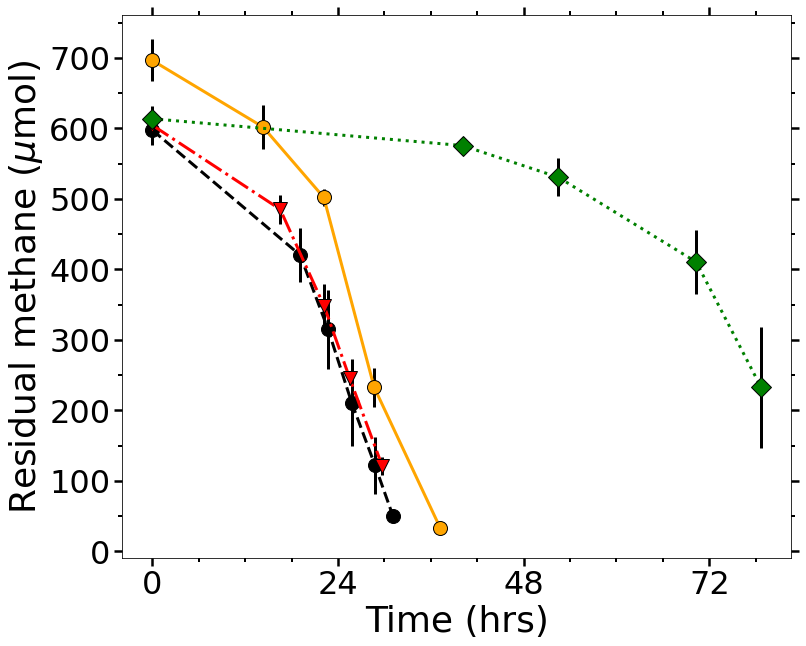

In [15]:
fig_gcf2, gcf2 = plt.subplots(figsize=(12,10))
fig_gct2, gct2 = plt.subplots(figsize=(12,10))
fig_met2, met2 = plt.subplots(figsize=(12,10))

# 37 C 1
gcf(od600_37_1,gcf2,"37 \u2103, exp1","o",'black')
gct(od600_37_1,gct2,"37 \u2103, exp1","--o",'black')
met(od600_37_1,met2,"37 \u2103, exp1","--o",'black')
# 7/20/2022 37C
gcf(od600_37_2,gcf2,"37 \u2103, exp2","o",'orange')
gct(od600_37_2,gct2,"37 \u2103, exp2","-o",'orange')
met(od600_37_2,met2,"37 \u2103, exp2","-o",'orange')
# Cu free 37C
gcf(od600_cuf,gcf2,"No-Cu","v",'red')
gct(od600_cuf,gct2,"No-Cu","-.v",'red')
met(od600_cuf,met2,"No-Cu","-.v",'red')
# 50 uM Cu 37C
gcf(od600_cuh,gcf2,"High-Cu","D",'green')
gct(od600_cuh,gct2,"High-Cu",":D",'green')
met(od600_cuh,met2,"High-Cu",":D",'green')

gcf2.set_yticklabels(gcf1.get_yticks(),fontdict=font_ticks)
gcf2.set_xticklabels(gcf1.get_xticks(),fontdict=font_ticks)
gcf2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
gcf2.invert_xaxis()
#gcf2.legend(fontsize=15)

gct2.set_ylim([-4,0])
gct2.set_xlabel('')
gct2.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32,
                top=True, right=True, labelbottom=False, labeltop=True)
gct2.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32,
                top=True, right=True)
gct2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
gct2.xaxis.set_minor_locator(ticker.MultipleLocator(6))
gct2.xaxis.set_major_locator(ticker.MultipleLocator(24))
gct2.yaxis.set_major_locator(ticker.MultipleLocator(1))
gct2.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
gct2.legend(fontsize=20)

#met2.plot(np.linspace(0,500,10),10*[0.66],"k--",linewidth=2.0,label="f=0.66")
#met2.set_xlim([0,48])
met2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
met2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# met1.legend(fontsize=15)
met2.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32,
                top=True, right=True)
met2.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32,
                top=True, right=True)
met2.yaxis.set_minor_locator(ticker.MultipleLocator(50))
met2.xaxis.set_major_locator(ticker.MultipleLocator(24))
met2.xaxis.set_minor_locator(ticker.MultipleLocator(6))

plt.show()
fig_gcf2.savefig("OD_f2.pdf", bbox_inches='tight')
fig_gct2.savefig("OD_t2.pdf", bbox_inches='tight')
fig_met2.savefig("CH4_t2.pdf", bbox_inches='tight')

[ 1.51524161 -1.98948754  2.10590104  3.66903692]


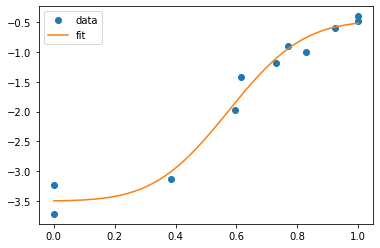

In [16]:
def sigmoid(x, x0, a, b, k):
    y = 1 / (a + b*np.exp(k*(x-x0)))
    return y

def errf(z,a,b,c,d):
    return a*scipy.special.erf(d*z-c)+b

def hyb(x,a,b,c,d):
    return a*np.tanh(b*x-d)+c

# xdata = np.array([0, 19.11519694, 22.72925444, 25.78049111, 28.79709444, 31.12027833,
#                  0, 14.33038056, 22.17432611, 28.67793722, 37.24494583])
# ydata = np.array([64.38909415, 45.27384631, 10.14255581, 6.797466681, 3.9259443, 1.610048702,
#                  81.88298178, 70.75619839, 25.58122264, 7.574458596, 1.062613574])

xdata=np.array([0,
0.614236053,
0.730367968,
0.828414542,
0.925348229,
1,
0,
0.384760408,
0.595364703,
0.769981982,
1])
ydata=np.array([-3.226404091,
-1.422958345,
-1.190727578,
-0.991553216,
-0.602392817,
-0.471604911,
-3.719338662,
-3.134994341,
-1.969690678,
-0.891598119,
-0.398241263])


popt, pcov = curve_fit(errf, xdata, ydata)
print(popt)

x = np.linspace(0, 1, 50)
y = errf(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
# pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()



[-482.59456385 -329.67331777   31.08443265  -61.88351501]


/Users/f005cbk/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


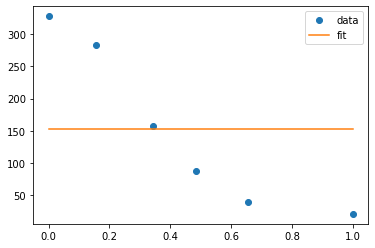

In [17]:
xdata=np.array([0,
0.155912454,
0.34214514,
0.48542179,
0.656156811,
1])
ydata=np.array([327.9010068,
283.9185743,
156.9845407,
88.23617649,
39.6750837,
20.81208783])


popt, pcov = curve_fit(errf, xdata, ydata)
print(popt)

x = np.linspace(0, 1, 50)
y = errf(x, *popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(x,y, label='fit')
# pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

0.00294383463178945 0.687754145637792
0.00014913576726820194 0.7689063306466896
0.0023897106254055305 0.045107132427099406


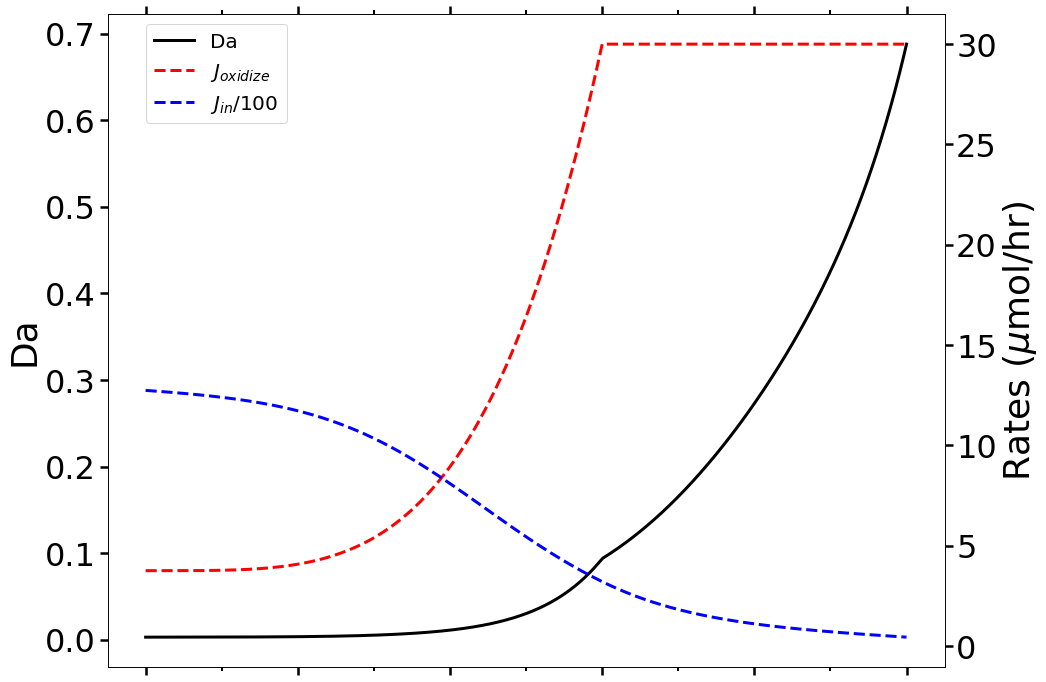

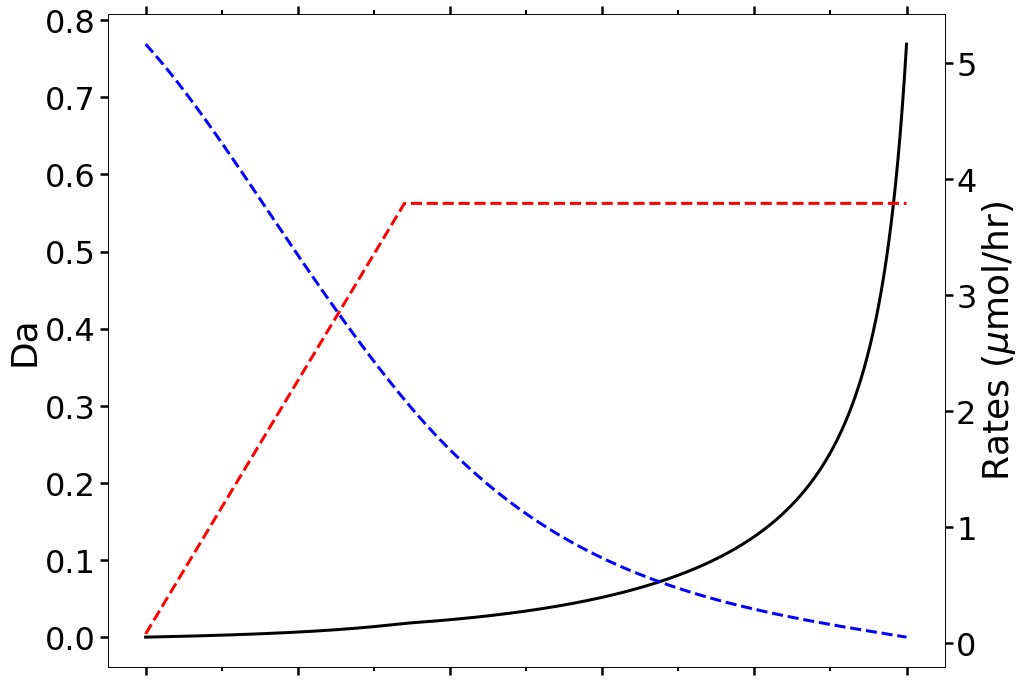

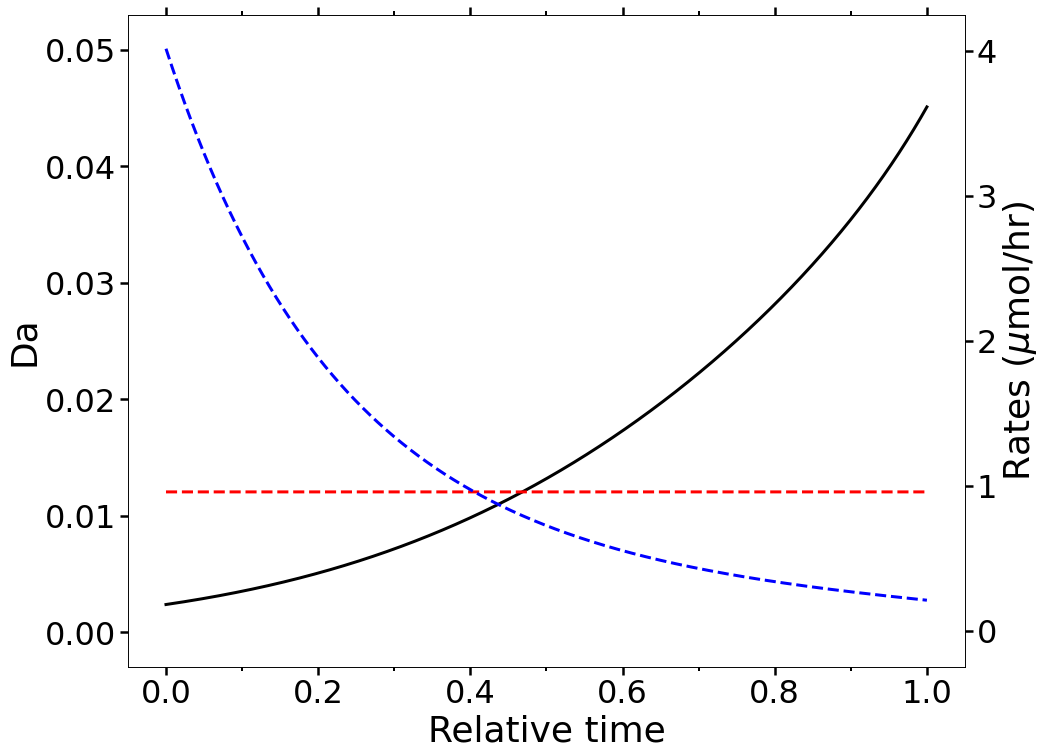

In [18]:
# Define a function to plot
def pltDa(ax,t,Jo,Jin,Da):
    ax.plot(t,Da,'-k',linewidth=3.0,label="Da")
    axJ=ax.twinx()
    axJ.plot(t,Jo,'--r',linewidth=3.0, label="$J_{oxidize}$")
    axJ.plot(t,Jin/100,'--b',linewidth=3.0, label="$J_{in}/100$")
    ax.set_xlabel('Relative time', fontdict = font_labels)
    ax.set_ylabel('Da', fontdict = font_labels)
    axJ.set_ylabel('Rates ($\mu$mol/hr)', fontdict = font_labels)
    ax.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32)
    ax.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32)
    axJ.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    return ax, axJ

t37=np.linspace(0.0001,28.0,10000)
t27=np.linspace(0.0001,195.0,10000)
t21=np.linspace(0.0001,508.0,10000)
# Relative time
t37r=t37/28.0
t27r=t27/195.0
t21r=t21/508.0
# Prepare the axes
figDa37,axDa37=plt.subplots(figsize=(15,12))
figDa27,axDa27=plt.subplots(figsize=(15,12))
figDa21,axDa21=plt.subplots(figsize=(15,12))
# For 37 C
Ko0=3.75
Kom=30.0
tc=0.6
tCH4_out=650.0
tr=t37r
Jo=np.zeros(len(tr))
Jin=np.zeros(len(tr))
Da=np.zeros(len(tr))
for i in range(len(tr)):
    if tr[i]<=tc:
        Jo[i]=Ko0+(Kom-Ko0)/0.6**4*tr[i]**4
    else:
        Jo[i]=Kom
    Jin[i]=0.19/math.exp(2/3*(1.51524161*scipy.special.erf(3.66903692*tr[i]-2.10590104)-1.98948754))*tCH4_out
    tCH4_out=tCH4_out-Jo[i]*(t37[1]-t37[0])
    Da[i]=Jo[i]/Jin[i]

axDa37,axDa37J=pltDa(axDa37,t37r,Jo,Jin,Da)
# axDa37.set_xlim([-1,31])
axDa37.set_xlabel('')
axDa37.tick_params(which='both',top=True, labelbottom=False)
figDa37.legend(bbox_to_anchor=(0.3,0.88), fontsize=20)
print(Da[0],Da[len(Da)-1])

# For 27 C
Ko0=0.077
Kom=3.79
tc=0.34
tCH4_out=650.0
tr=t27r
Jo=np.zeros(len(tr))
Jin=np.zeros(len(tr))
Da=np.zeros(len(tr))
for i in range(len(tr)):
    if tr[i]<=tc:
        Jo[i]=Ko0+(Kom-Ko0)/0.34*tr[i]
    else:
        Jo[i]=Kom
    Jin[i]=0.08/math.exp(2/3*(-3.462*tr[i]**3+3.9595*tr[i]**2+2.0572*tr[i]-3.4433))*tCH4_out
    tCH4_out=tCH4_out-Jo[i]*(t27[1]-t27[0])
    Da[i]=Jo[i]/Jin[i]

axDa27,axDa27J=pltDa(axDa27,t27r,Jo,Jin,Da)
axDa27.set_xlabel('')
axDa27.tick_params(which='both',top=True, labelbottom=False)
print(Da[0],Da[len(Da)-1])

# For 21 C
Kom=0.96
tCH4_out=650.0
tr=t21r
Jo=np.zeros(len(tr))
Jin=np.zeros(len(tr))
Da=np.zeros(len(tr))
for i in range(len(tr)):
    Jo[i]=Kom
    Jin[i]=0.06/math.exp(2/3*(-0.4127*tr[i]**3-2.1616*tr[i]**2+4.9*tr[i]-3.4983))*tCH4_out
    tCH4_out=tCH4_out-Jo[i]*(t21[1]-t21[0])
    Da[i]=Jo[i]/Jin[i]

axDa21,axDa21J=pltDa(axDa21,t21r,Jo,Jin,Da)
axDa21.tick_params(which='both',top=True)
axDa21.set_ylim([-0.003,0.053])
axDa21J.set_ylim([-0.25,4.25])
axDa21J.yaxis.set_major_locator(ticker.MultipleLocator(1))

print(Da[0],Da[len(Da)-1])
figDa37.savefig("Da37.pdf",bbox_inches='tight')
figDa27.savefig("Da27.pdf",bbox_inches='tight')
figDa21.savefig("Da21.pdf",bbox_inches='tight')

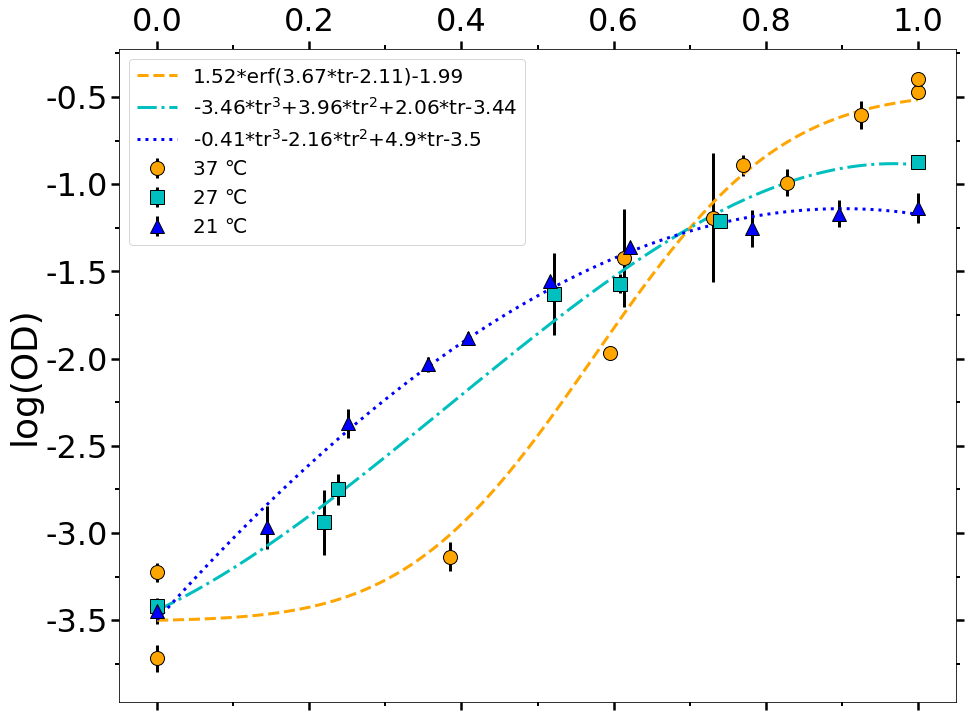

In [19]:
# Relative timescale
def gcrt(raw_data,ax,name,style,c):
    growthdf=pd.read_excel(raw_data)
    elapse_time=[0]
    OD=growthdf["avgOD"]
    ODerr=growthdf["stdevOD"]
    # mask=np.isfinite(growthdf["f"])
    for i in range (len(growthdf['Timestamp'])-1):
        elapse_time.append((growthdf['Timestamp'][i+1]-growthdf['Timestamp'][0])/pd.to_timedelta(1, unit='hr')) 
        # Covert the time difference to hrs
    rt=np.zeros(len(elapse_time))
    for i in range(len(elapse_time)):
        rt[i]=elapse_time[i]/max(elapse_time)  
    if logscale==False:
        ax.errorbar(rt, OD, yerr=ODerr, 
                    fmt=style, color=c, markerfacecolor=c, markeredgecolor='black', ecolor='black', label=name,
                    linewidth=3, markersize = 14)
    if logscale==True:
        ax.errorbar(rt, np.log(OD), yerr=ODerr/OD, 
                    fmt=style, color=c, markerfacecolor=c, markeredgecolor='black', ecolor='black',label=name,
                    linewidth=3, markersize = 14)
    ax.set_xlabel('Relative time',fontdict=font_labels)
    ax.set_ylabel('log(OD)',fontdict=font_labels)

od600_27_clean = "27C/2021-06-09_27C_McapsForClumps_OD600s (Responses)_clean.xlsx"
ODm,axODm=plt.subplots(figsize=(15,12))
# Plot the regression lines for logOD
t=np.linspace(0,1,100)
mod=np.zeros(len(t))
gcrt(od600_37_1,axODm,"37 \u2103","o",'orange')
gcrt(od600_37_2,axODm,"","o",'orange')
gcrt(od600_27_clean,axODm,"27 \u2103","s",'c')
gcrt(od600_21,axODm,"21 \u2103","^",'b')

# 37
for i in range(len(t)):
    mod[i]=1.51524161*scipy.special.erf(3.66903692*t[i]-2.10590104)-1.98948754
axODm.plot(t,mod,'--',linewidth=3.0, color='orange',
          label='1.52*erf(3.67*tr-2.11)-1.99')
# 27
for i in range(len(t)):    
    mod[i]= -3.462*t[i]**3 + 3.9595*t[i]**2 + 2.0572*t[i] - 3.4433
axODm.plot(t,mod,'-.c',linewidth=3.0,
          label='-3.46*tr$^3$+3.96*tr$^2$+2.06*tr-3.44')

# 21
for i in range(len(t)):    
    mod[i]= -0.4127*t[i]**3 - 2.1616*t[i]**2 + 4.9*t[i] - 3.4983
axODm.plot(t,mod,':b',linewidth=3.0,
          label='-0.41*tr$^3$-2.16*tr$^2$+4.9*tr-3.5')

axODm.set_xlabel('')
axODm.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
axODm.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# met1.legend(fontsize=15)
axODm.tick_params(which='major',direction='out', length=8, width=2.5, labelsize=32,
                 top=True, right=True, labelbottom=False, labeltop=True)
axODm.tick_params(which='minor',direction='out', length=4, width=2.0, labelsize=32,
                 top=True, right=True)
axODm.yaxis.set_minor_locator(ticker.MultipleLocator(0.25))
# axODm.xaxis.set_major_locator(ticker.MultipleLocator(24))
axODm.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

axODm.legend(fontsize=20)
ODm.savefig("ODm.pdf", bbox_inches='tight')